In [1]:
from mpi4py import MPI
import gmsh
import numpy as np
from scipy.spatial import cKDTree
import pyvista as pv
from dolfinx import plot

# 1) Load MRST data (Pa) with header x,y,pressure
# data = np.loadtxt("pressure_field_lagrange_example1.csv", delimiter=",", skiprows=1)
# x_mrst, y_mrst, p_mrst = data[:, 0], data[:, 1], data[:, 2]

# --- before the refinement loop (rank 0 only collects) ---
h_list, L2_list, L2_fem_list, rL2_list, rL2s_fem_list, H1s_list, rH1s_list = [], [], [], [], [], [], []
L2_fem_list_pf, rL2s_fem_list_pf, H1s_list_pf, rH1s_list_pf = [], [], [], []
L2_fem_list_lmbd, rL2s_fem_list_lmbd, H1s_list_lmbd, rH1s_list_lmbd = [], [], [], []

plotter = pv.Plotter(shape=(2, 4), window_size=(2000, 1000))
N_ref = 10

Lx, Ly = 1.0, 1.0
y_start, y_end = 0.0, 1.0
x_start, x_end = 0.25, 0.75


In [ ]:
#MESH GENERATION
for ref in range(N_ref+1):
    # Initialize gmsh
    gmsh.initialize()
    gmsh.option.setNumber("General.Terminal", 0)
    gmsh.model.add("rect_with_partial_interface")

    if MPI.COMM_WORLD.rank == 0:
        # --------------------------
        # Parameters
        # --------------------------

        lc = 1.0/ (2**ref)          # mesh size
        h = lc

        gmsh.option.setNumber("Mesh.MeshSizeMin", h)
        gmsh.option.setNumber("Mesh.MeshSizeMax", h)
        gmsh.option.setNumber("Mesh.SaveAll", 1)   # <-- add this before meshing
        # lc = 0.3
        order = 1          # element order

        # --------------------------
        # 1. Define rectangular domain Ω
        # --------------------------
        p1 = gmsh.model.occ.addPoint(0, 0, 0)
        p2 = gmsh.model.occ.addPoint(Lx, 0, 0)
        p3 = gmsh.model.occ.addPoint(Lx, Ly, 0)
        p4 = gmsh.model.occ.addPoint(0, Ly, 0)
        l1 = gmsh.model.occ.addLine(p1, p2)
        l2 = gmsh.model.occ.addLine(p2, p3)
        l3 = gmsh.model.occ.addLine(p3, p4)
        l4 = gmsh.model.occ.addLine(p4, p1)
        loop = gmsh.model.occ.addCurveLoop([l1, l2, l3, l4])
        surf = gmsh.model.occ.addPlaneSurface([loop])

        # --------------------------
        # 2. Add an internal partial horizontal line Γ
        # --------------------------
        p5 = gmsh.model.occ.addPoint(x_start, y_start, 0)
        p6 = gmsh.model.occ.addPoint(x_end, y_end, 0)
        l5 = gmsh.model.occ.addLine(p5, p6)

        # --------------------------
        # 3. Fragment the surface with the internal line (split mesh)
        # --------------------------
        gmsh.model.occ.fragment([(2, surf)], [(1, l5)])
        gmsh.model.occ.synchronize()

        # --------------------------
        # 4. Define physical groups
        # --------------------------
        # Surface (bulk Ω)
        # gmsh.model.addPhysicalGroup(2, [surf], 1)
        # gmsh.model.setPhysicalName(2, 1, "Omega")
        omega = [t for (d, t) in gmsh.model.getEntities(2)]
        gmsh.model.addPhysicalGroup(2, omega, 1)
        gmsh.model.setPhysicalName(2, 1, "Omega")

        # Identify the internal line (Γ)
        # 2) Recompute ALL post-fragment edges from surface boundaries
        from collections import Counter

        all_edges = []
        for s in omega:
            # boundary curves of each surface
            b = gmsh.model.getBoundary([(2, s)], oriented=False, recursive=False)
            all_edges.extend([t for (d, t) in b])

        counts = Counter(all_edges)

        # Outer boundary edges (belong to exactly one surface)
        boundary_curves = [t for t, c in counts.items() if c == 1]

        if boundary_curves:
            pgB = gmsh.model.addPhysicalGroup(1, boundary_curves, 3)   # id=3 for Boundary
            gmsh.model.setPhysicalName(1, pgB, "Boundary")

        # 3) Gamma = all 1D curves that are NOT in Boundary
        all_1d = [t for (d, t) in gmsh.model.getEntities(1)]
        boundary_1d = set(gmsh.model.getEntitiesForPhysicalGroup(1, 3))  # id=3
        gamma_curves = [t for t in all_1d if t not in boundary_1d]

        if gamma_curves:
            gmsh.model.addPhysicalGroup(1, gamma_curves, 2)   # id=2 for Gamma
            gmsh.model.setPhysicalName(1, 2, "Gamma")

        # --------------------------
        # 5. Generate and save mesh
        # --------------------------
        # print("Physical groups (dim, tag):", gmsh.model.getPhysicalGroups())
        # print("Gamma curves:", gmsh.model.getEntitiesForPhysicalGroup(1, 2))

        gmsh.model.mesh.generate(2)
        gmsh.model.mesh.setOrder(order)
        filename = f"diagonal_fracture_ex1_{ref}.msh"
        gmsh.write(filename)
    gmsh.finalize()

In [ ]:
from mpi4py import MPI
from dolfinx import mesh, fem
from dolfinx.io import gmsh as gmshio
from dolfinx.mesh import locate_entities_boundary
import ufl
import numpy as np

# ---------------------------------------------------------------------
# 1. Mesh and interface tags (conforming Ω + Γ as in your CG code)
# ---------------------------------------------------------------------
ref = 2
filename = f"diagonal_fracture_ex1_{ref}.msh"
omega, cell_markers, facet_markers = gmshio.read_from_msh(
    filename, MPI.COMM_WORLD, 0, gdim=2
)[0:3]

tdim = omega.topology.dim  # 2
fdim = tdim - 1            # 1

# mesh size (same style as your CG code)
lc = 1.0 / (2**ref)
h = lc

# Interface tag (from Gmsh)
Gamma_tag = 2

# Find all facets tagged as Gamma (tag=2) on Ω and build conforming submesh Γ
gamma_entities = facet_markers.find(Gamma_tag)
gamma, gamma_to_omega = mesh.create_submesh(omega, fdim, gamma_entities)[0:2]

# ---------------------------------------------------------------------
# 2. Function spaces (MIXED on Ω, CG on Γ)
# ---------------------------------------------------------------------
order = 1  # RT order; scalar spaces use order-1

Sigma_m = fem.functionspace(omega, ("RT", order))
V_m     = fem.functionspace(omega, ("DG", order-1))
Sigma_f = fem.functionspace(gamma, ("RT", order))
V_f     = fem.functionspace(gamma, ("DG", order-1))
V_l     = fem.functionspace(gamma, ("Discontinuous Lagrange", order-1))  # Lagrange multiplier λ

# W = ufl.MixedFunctionSpace(Sigma_m, V_m, Sigma_f, V_f, V_l)
mixed_elem = ufl.MixedElement(
    Sigma_m.ufl_element(),
    V_m.ufl_element(),
    Sigma_f.ufl_element(),
    V_f.ufl_element(),
    V_l.ufl_element()
)
W = fem.FunctionSpace(omega, mixed_elem)

# Test / trial functions on the mixed space
w_m, q_m, w_f, q_f, mu = ufl.TestFunctions(W)
dv_m, dp_m, dv_f, dp_f, dl = ufl.TrialFunctions(W)

# Solution functions (one per component, like your first code)
v_m  = fem.Function(Sigma_m, name="u_m")
p_m  = fem.Function(V_m,     name="p_m")
v_f  = fem.Function(Sigma_m, name="u_m")
p_f  = fem.Function(V_f,     name="p_f")
lmbd = fem.Function(V_l,     name="lmbd")

# ---------------------------------------------------------------------
# 3. Measures, coefficients, data
# ---------------------------------------------------------------------
dx = ufl.Measure("dx", domain=omega)
ds = ufl.Measure("ds", domain=omega,
                       subdomain_data=facet_markers,
                       subdomain_id=Gamma_tag)
dx_f = ufl.Measure("dx", domain=gamma)
ds_Omega = ufl.Measure("ds", domain=omega)
ds_Gamma = ufl.Measure("ds", domain=omega)
n = ufl.FacetNormal(omega)

# Bulk coefficients
k_m = fem.Constant(omega, 1.0)
f_m = fem.Constant(omega, 0.0)

# Interface coefficients
k_f = fem.Constant(gamma, 10.0)
f_f = fem.Constant(gamma, 0.0)

# ---------------------------------------------------------------------
# 4. Geometry / boundaries of Ω (re-using your CG-style logic)
# ---------------------------------------------------------------------
coords = omega.geometry.x
xx = coords[:, 0]
yy = coords[:, 1]

xmin, xmax = xx.min(), xx.max()
ymin, ymax = yy.min(), yy.max()

tol = 1e-10 * max(xmax - xmin, ymax - ymin)

# Boundary facets
bottom_facets = locate_entities_boundary(
    omega, fdim, lambda x: np.isclose(x[1], ymin, atol=tol)
)
top_facets = locate_entities_boundary(
    omega, fdim, lambda x: np.isclose(x[1], ymax, atol=tol)
)
left_facets = locate_entities_boundary(
    omega, fdim, lambda x: np.isclose(x[0], xmin, atol=tol)
)
right_facets = locate_entities_boundary(
    omega, fdim, lambda x: np.isclose(x[0], xmax, atol=tol)
)

# ---------------------------------------------------------------------
# 5. Boundary conditions for p_m (Dirichlet on left & right)
# ---------------------------------------------------------------------
g_left = 1.0
g_right = 4.0

u_top = fem.Function(Sigma_m)
u_bottom = fem.Function(Sigma_m)

def top_flux_expr(x):
    # 2D vector: (u_x, u_y)
    return np.vstack((
        np.zeros_like(x[0]),          # u_x = 0
        -np.ones_like(x[0])           # u_y = -1
    ))

def bottom_flux_expr(x):
    return np.vstack((
        np.zeros_like(x[0]),          # u_x = 0
        -2.0 * np.ones_like(x[0])     # u_y = -2
    ))

u_top.interpolate(top_flux_expr)
u_bottom.interpolate(bottom_flux_expr)

top_dofs_sigma = fem.locate_dofs_topological(Sigma_m, fdim, top_facets)
bottom_dofs_sigma = fem.locate_dofs_topological(Sigma_m, fdim, bottom_facets)

bc_top = fem.dirichletbc(u_top, top_dofs_sigma)
bc_bottom = fem.dirichletbc(u_bottom, bottom_dofs_sigma)

# ---------------------------------------------------------------------
# 7. Interface BCs for p_f on Γ tips (same as your CG code)
# ---------------------------------------------------------------------
tol_g = 1e-10 * np.max(np.ptp(gamma.geometry.x, axis=0))

# Collect all BCs (flux on top/bottom + bulk p_m + interface p_f)
# bcs = [bc_top, bc_bottom, bc_pf]
bcs = [bc_top, bc_bottom]

# UFL coordinates for BC expressions
x_ufl = ufl.SpatialCoordinate(omega)

g_left  = 1.0
g_right = 4.0

# Dirichlet data for p_m on left/right (weak in mixed form)
g_D = ufl.conditional(
    ufl.lt(abs(x_ufl[0] - xmin), tol), g_left,
    ufl.conditional(
        ufl.lt(abs(x_ufl[0] - xmax), tol), g_right,
        0.0
    )
)

# indicator functions for each tip
is_tip1 = ufl.And(
    ufl.lt(abs(x_ufl[0] - x_start), tol),
    ufl.lt(abs(x_ufl[1] - y_start), tol)
)

is_tip2 = ufl.And(
    ufl.lt(abs(x_ufl[0] - x_end), tol),
    ufl.lt(abs(x_ufl[1] - y_end), tol)
)

# Dirichlet data
gf_D = ufl.conditional(
    is_tip1, 1.0,
    ufl.conditional(
        is_tip2, 4.0,
        0.0
    )
)

# ---------------------------------------------------------------------
# 8. Weak forms (mixed in Ω + CG with multiplier on Γ, conforming case)
# ---------------------------------------------------------------------
# Bulk mixed form on Ω
a_m0 = (
    ufl.inner(v_m, w_m)              
    - p_m * ufl.div(k_m * w_m)       
    + q_m * ufl.div(v_m)             
) * dx

# Coupling to λ on Γ (no averages needed in conforming case)
# a_m1 = - lmbd * q_m * ds_gamma #old
a_m1 = p_f * ufl.dot(k_m*w_m, n) * ds
a_m1 += - lmbd * q_m * ds

a_m = a_m0 + a_m1

L_m = f_m * q_m * dx - g_D * ufl.dot(k_m*w_m, n) * ds_Omega 

# Interface Γ: diffusion in p_f + λ coupling
# a_f0 = ufl.inner(k_f * ufl.grad(p_f), ufl.grad(psi)) * ds_gamma
a_f0 = (
    ufl.inner(v_f, w_f)              
    - p_f * ufl.div(k_f * w_f)       
    + q_f * ufl.div(v_f)             
) * ds
a_f1 = lmbd * q_f * ds
a_f  = a_f0 + a_f1
L_f  = f_f * q_f * ds

# Multiplier equation enforcing p_m|_Γ = p_f on Γ
a_l0 = p_m * mu * ds
a_l1 = -p_f * mu * ds
a_l  = a_l0 + a_l1
L_l  = fem.Constant(omega, 0.0) * mu * ds - gf_D * ufl.dot(k_f*w_f, n) * ds_Gamma

# Combine all
a_gamma = a_f + a_l
L_gamma = L_f + L_l

F = a_m - L_m + a_gamma - L_gamma

# Block residual & Jacobian for the mixed system
residual = ufl.extract_blocks(F)
jac = (
    ufl.derivative(F, v_m,  dv_m)
    + ufl.derivative(F, p_m, dp_m)
    + ufl.derivative(F, v_f,  dv_f)
    + ufl.derivative(F, p_f, dp_f)
    + ufl.derivative(F, lmbd, dl)
)
J = ufl.extract_blocks(jac)

# ---------------------------------------------------------------------
# 9. Solve with block NonlinearProblem (linear system, but reuse your pattern)
# ---------------------------------------------------------------------
from dolfinx.fem import petsc

entity_maps = [gamma_to_omega]
# petsc_options = {
#     "snes_monitor": None,
#     "snes_max_it": 50,
#     "ksp_type": "preonly",
#     "pc_type": "lu",
#     "pc_factor_mat_solver_type": "mumps",

#     # tried already but keep high
#     "mat_mumps_icntl_14": 800,

#     # OOC + allowance (set to match node resources)
#     "mat_mumps_icntl_22": 1,      # enable out-of-core
#     "mat_mumps_icntl_23": 16000,  # per-proc OOC memory limit in MB (try 16 GB)

#     # more verbose diagnostics
#     "mat_mumps_icntl_4": 3,
#     "mat_mumps_icntl_1": 6,
#     "mat_mumps_icntl_2": 6,

#     # optional: reduce aggressive memory request if you want to test lower
#     # "mat_mumps_icntl_14": 200, 

#     "ksp_error_if_not_converged": True,
#     "snes_error_if_not_converged": True,
# }
petsc_options = {
    "snes_monitor": None,
    "snes_max_it": 50,

    # Use preonly with fieldsplit so the "pc" handles the block solves
    "ksp_type": "preonly",
    "pc_type": "fieldsplit",

    # choose the fieldsplit layout & type
    "pc_fieldsplit_type": "schur",          # use 'additive' or 'multiplicative' alternatives
    "pc_fieldsplit_schur_factorization_type": "full",  # or 'upper'

    # configure split solvers (split names depend on how you registered fields)
    # assume split0 = velocity block, split1 = pressure block (example)
    "fieldsplit_0_ksp_type": "preonly",
    "fieldsplit_0_pc_type": "hypre",
    "fieldsplit_1_ksp_type": "preonly",
    "fieldsplit_1_pc_type": "ilu",

    # global fallbacks
    "ksp_error_if_not_converged": True,
    "snes_error_if_not_converged": True,
}

nlp = petsc.NonlinearProblem(
    residual,
    u=[v_m, p_m, v_f, p_f, lmbd],
    J=J,
    bcs=bcs,
    entity_maps=entity_maps,
    petsc_options=petsc_options,
    petsc_options_prefix="pmix_conf_",
)

nlp.solve()
iterations = nlp.solver.getIterationNumber()
print(f"Converged in {iterations} Newton iterations")

# For convenience
v_m_exact  = v_m
p_m_exact  = p_m
v_f_exact  = v_f
p_f_exact  = p_f
lmbd_exact = lmbd

Info    : Reading 'diagonal_fracture_ex1_2.msh'...
Info    : 15 entities
Info    : 32 nodes
Info    : 73 elements
Info    : Done reading 'diagonal_fracture_ex1_2.msh'
  0 SNES Function norm 8.397071863816e+00


Error: error code 77
[0] SNESSolve() at /home/conda/feedstock_root/build_artifacts/bld/rattler-build_petsc_1759674433/work/src/snes/interface/snes.c:4906
[0] SNESSolve_NEWTONLS() at /home/conda/feedstock_root/build_artifacts/bld/rattler-build_petsc_1759674433/work/src/snes/impls/ls/ls.c:220
[0] KSPSolve() at /home/conda/feedstock_root/build_artifacts/bld/rattler-build_petsc_1759674433/work/src/ksp/ksp/interface/itfunc.c:1090
[0] KSPSolve_Private() at /home/conda/feedstock_root/build_artifacts/bld/rattler-build_petsc_1759674433/work/src/ksp/ksp/interface/itfunc.c:839
[0] KSPSetUp() at /home/conda/feedstock_root/build_artifacts/bld/rattler-build_petsc_1759674433/work/src/ksp/ksp/interface/itfunc.c:429
[0] PCSetUp() at /home/conda/feedstock_root/build_artifacts/bld/rattler-build_petsc_1759674433/work/src/ksp/pc/interface/precon.c:1120
[0] PCSetUp_FieldSplit() at /home/conda/feedstock_root/build_artifacts/bld/rattler-build_petsc_1759674433/work/src/ksp/pc/impls/fieldsplit/fieldsplit.c:584
[0] PCFieldSplitSetDefaults() at /home/conda/feedstock_root/build_artifacts/bld/rattler-build_petsc_1759674433/work/src/ksp/pc/impls/fieldsplit/fieldsplit.c:546
[0] PETSc has generated inconsistent data
[0] Unhandled case, must have at least two fields, not 1

In [24]:
from dolfinx.io import XDMFFile
import pathlib

outdir = pathlib.Path("result_conforming_case4_mixedfem_dg")
outdir.mkdir(exist_ok=True)

from dolfinx.io import XDMFFile

# ------------------------------
# 1) Save bulk field p_m on Ω
# ------------------------------
omega_file = outdir / "omega_finest.xdmf"
with XDMFFile(omega.comm, str(omega_file), "w") as xdmf:
    xdmf.write_mesh(omega)
    xdmf.write_function(p_m_exact)

# ------------------------------
# 2) Save interface fields p_f, λ on Γ
# ------------------------------
gamma_file = outdir / "gamma_finest.xdmf"
with XDMFFile(gamma.comm, str(gamma_file), "w") as xdmf:
    xdmf.write_mesh(gamma)
    xdmf.write_function(p_f_exact)
    xdmf.write_function(lmbd_exact)

In [3]:
from mpi4py import MPI
import numpy as np
from petsc4py import PETSc
from dolfinx import fem, geometry
import ufl

def l2_h1_errors_proj(p, p_exact, comm=MPI.COMM_WORLD):
    """
    Compare coarse solution `p` to the L2-projection of `p_exact` (defined on a fine mesh)
    onto the coarse function space of `p`. Returns (err_L2, err_H1_full, rel_L2, rel_H1_full).
    Works on recent dolfinx without QuadratureElement / ufl.FiniteElement.
    """
    Vc = p.function_space
    mesh_coarse = Vc.mesh
    mesh_fine   = p_exact.function_space.mesh
    tdim = mesh_fine.topology.dim
    gdim = mesh_coarse.geometry.dim

    # Choose a quadrature degree high enough for your coarse degree and p_exact variation
    k = Vc.ufl_element().degree
    q = 2 * k + 2
    dx = ufl.dx(domain=mesh_coarse, metadata={"quadrature_degree": q})

    # --- Build search trees on the FINE mesh (to evaluate p_exact at arbitrary points) ---
    bbt_fine = geometry.bb_tree(mesh_fine, tdim)
    mid_tree_fine = geometry.create_midpoint_tree(
        mesh_fine, tdim,
        np.arange(mesh_fine.topology.index_map(tdim).size_local, dtype=np.int32)
    )

    def eval_p_exact_on_points(x: np.ndarray) -> np.ndarray:
        """
        Evaluate p_exact (living on the FINE mesh) at physical points x (on coarse cells).
        x has shape (gdim, N); return shape (1, N) for scalar fields.
        """
        _gdim, N = x.shape
        if _gdim != gdim:
            raise ValueError(f"Point array has gdim={_gdim}, expected {gdim}")

        # dolfinx expects 3D coordinates; pad in 2D
        if gdim == 2:
            X3 = np.column_stack([x.T, np.zeros(N, dtype=np.float64)])  # (N, 3)
        elif gdim == 3:
            X3 = x.T.copy()                                             # (N, 3)
        else:
            raise ValueError(f"Unsupported geometric dimension gdim={gdim}")

        # candidate & colliding cells on the fine mesh
        cands = geometry.compute_collisions_points(bbt_fine, X3)
        hits = geometry.compute_colliding_cells(mesh_fine, cands, X3)

        cells = np.full(N, -1, dtype=np.int32)
        for i in range(N):
            li = hits.links(i)
            if len(li) > 0:
                cells[i] = li[0]

        # fallback to nearest entity if a point sits barely outside (roundoff)
        missing = np.where(cells == -1)[0]
        if missing.size > 0:
            nearest = geometry.compute_closest_entity(bbt_fine, mid_tree_fine, mesh_fine, X3[missing])
            cells[missing] = nearest

        vals = p_exact.eval(X3, cells)   # shape (N,) for scalar field
        return np.asarray(vals, dtype=np.float64).reshape(1, N)

    # --- L2 projection: assemble M c = b with b_i = ∫ p_exact * φ_i dx  (φ_i test funcs on coarse mesh)
    u = ufl.TrialFunction(Vc)
    v = ufl.TestFunction(Vc)

    # Mass matrix on coarse space
    a = ufl.inner(u, v) * dx

    # RHS uses an Expression that evaluates p_exact at coarse quadrature points
    expr = fem.Expression(eval_p_exact_on_points)  # let dolfinx pick points from dx metadata
    # In recent dolfinx, you can pass Expression directly into a UFL form with *the same* dx metadata:
    L = ufl.inner(expr, v) * dx

    A = fem.petsc.assemble_matrix(fem.form(a))
    A.assemble()
    b = fem.petsc.assemble_vector(fem.form(L))

    p_proj = fem.Function(Vc)
    ksp = PETSc.KSP().create(comm)
    ksp.setOperators(A)
    ksp.setType(PETSc.KSP.Type.CG)
    ksp.getPC().setType(PETSc.PC.Type.JACOBI)
    ksp.setFromOptions()
    ksp.solve(b, p_proj.vector)
    p_proj.vector.assemble()

    # --- Errors of p against the L2-projected reference
    err = p - p_proj

    # ||err||_L2^2 and |err|_H1^2
    L2_sq_local = fem.assemble_scalar(fem.form(ufl.inner(err, err) * dx))
    H1_semi_sq_local = fem.assemble_scalar(fem.form(ufl.inner(ufl.grad(err), ufl.grad(err)) * dx))

    L2_sq = comm.allreduce(L2_sq_local, op=MPI.SUM)
    H1_semi_sq = comm.allreduce(H1_semi_sq_local, op=MPI.SUM)

    err_L2 = np.sqrt(L2_sq)
    err_H1_full = np.sqrt(L2_sq + H1_semi_sq)

    # Norms of the projected exact (for relative errors in the same space)
    L2_proj_sq_local = fem.assemble_scalar(fem.form(ufl.inner(p_proj, p_proj) * dx))
    H1_proj_sq_local = fem.assemble_scalar(fem.form(ufl.inner(ufl.grad(p_proj), ufl.grad(p_proj)) * dx))

    L2_proj_sq = comm.allreduce(L2_proj_sq_local, op=MPI.SUM)
    H1_proj_sq = comm.allreduce(H1_proj_sq_local, op=MPI.SUM)

    exact_L2 = np.sqrt(L2_proj_sq)
    exact_H1_full = np.sqrt(L2_proj_sq + H1_proj_sq)

    rel_L2 = (err_L2 / exact_L2) if exact_L2 > 0 else (0.0 if err_L2 == 0 else np.inf)
    rel_H1_full = (err_H1_full / exact_H1_full) if exact_H1_full > 0 else (0.0 if err_H1_full == 0 else np.inf)

    return err_L2, err_H1_full, rel_L2, rel_H1_full


Info    : Reading 'diagonal_fracture_ex1_0.msh'...
Info    : 15 entities
Info    : 7 nodes
Info    : 20 elements
Info    : Done reading 'diagonal_fracture_ex1_0.msh'
DOFs in p_m: 7
DOFs in p_f: 3
DOFs in λ: 3
Total DOFs: 13
  0 SNES Function norm 5.209285283374e+01
  1 SNES Function norm 7.984830970218e-15
Converged in 1 Newton iterations


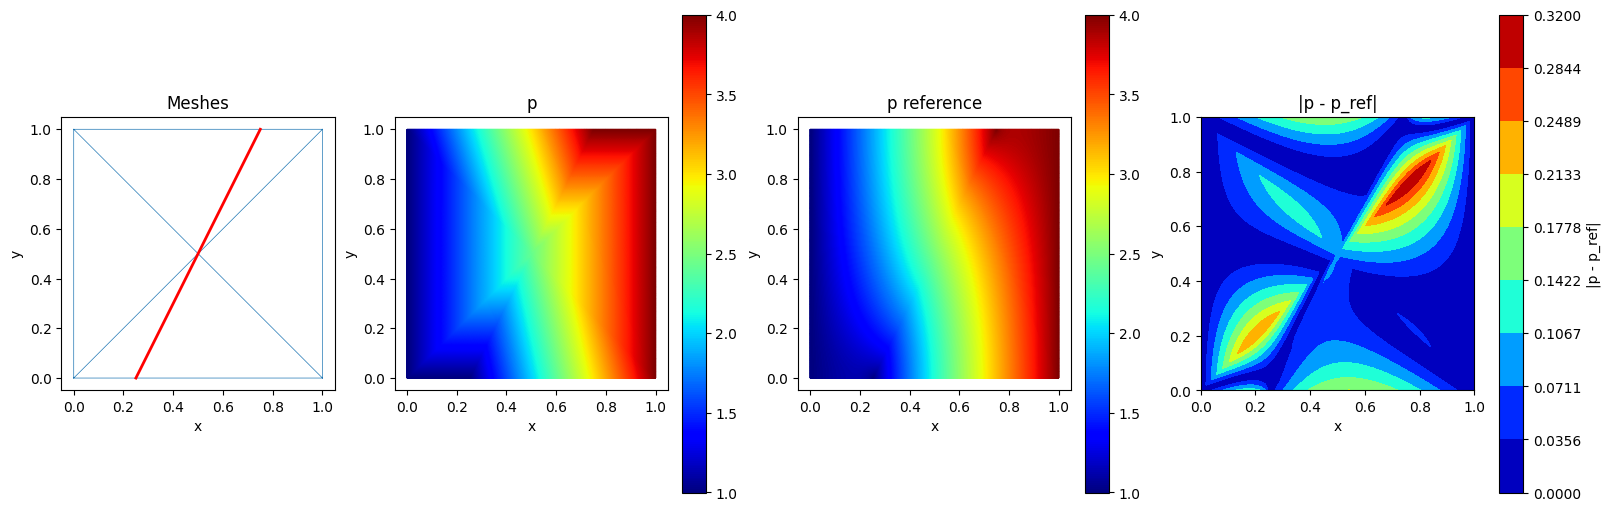

Info    : Reading 'diagonal_fracture_ex1_1.msh'...
Info    : 15 entities
Info    : 16 nodes
Info    : 39 elements
Info    : Done reading 'diagonal_fracture_ex1_1.msh'
DOFs in p_m: 16
DOFs in p_f: 4
DOFs in λ: 4
Total DOFs: 24
  0 SNES Function norm 1.278506259420e+02
  1 SNES Function norm 1.474240067252e-13
Converged in 1 Newton iterations


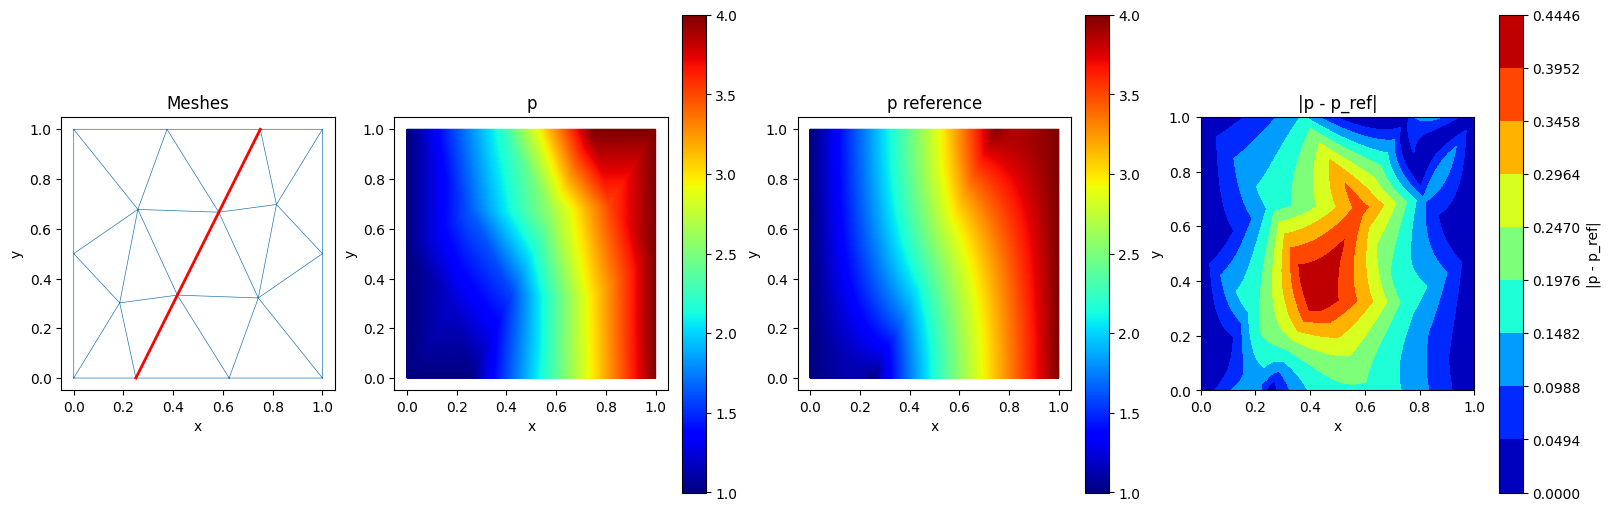

Info    : Reading 'diagonal_fracture_ex1_2.msh'...
Info    : 15 entities
Info    : 32 nodes
Info    : 73 elements
Info    : Done reading 'diagonal_fracture_ex1_2.msh'
DOFs in p_m: 32
DOFs in p_f: 6
DOFs in λ: 6
Total DOFs: 44
  0 SNES Function norm 2.618502030820e+02
  1 SNES Function norm 7.536269727459e-13
Converged in 1 Newton iterations


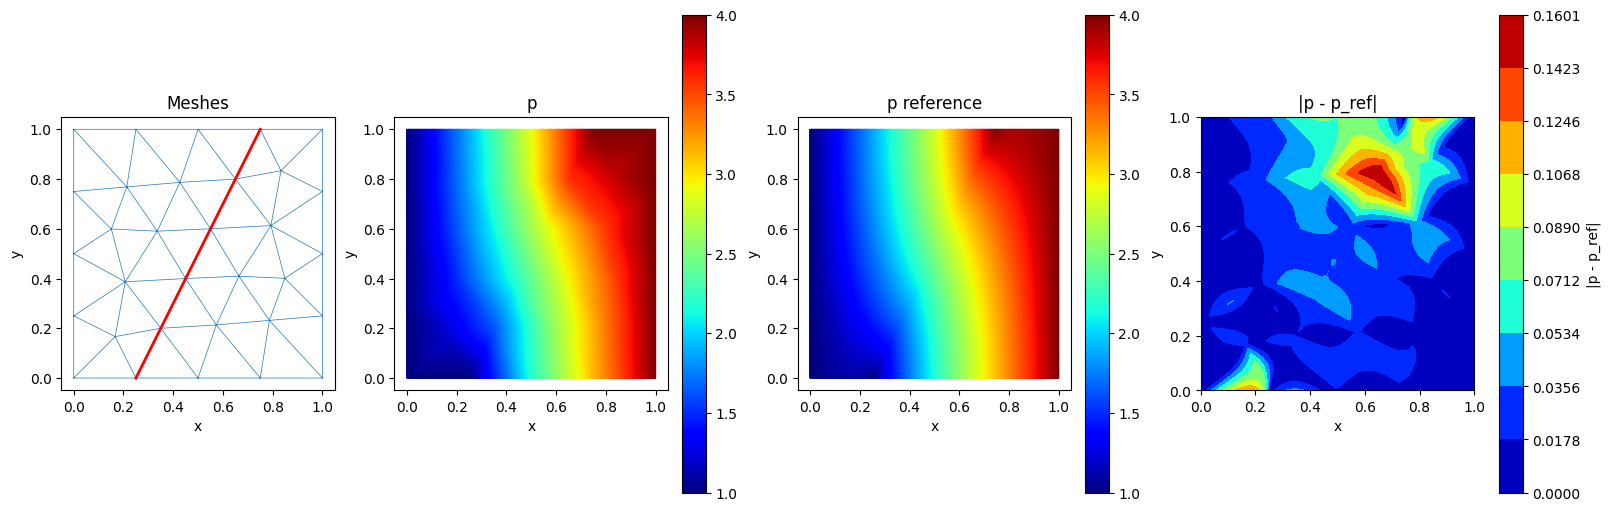

Info    : Reading 'diagonal_fracture_ex1_3.msh'...
Info    : 15 entities
Info    : 94 nodes
Info    : 201 elements
Info    : Done reading 'diagonal_fracture_ex1_3.msh'
DOFs in p_m: 94
DOFs in p_f: 10
DOFs in λ: 10
Total DOFs: 114
  0 SNES Function norm 3.565153605571e+02
  1 SNES Function norm 2.661739738943e-12
Converged in 1 Newton iterations


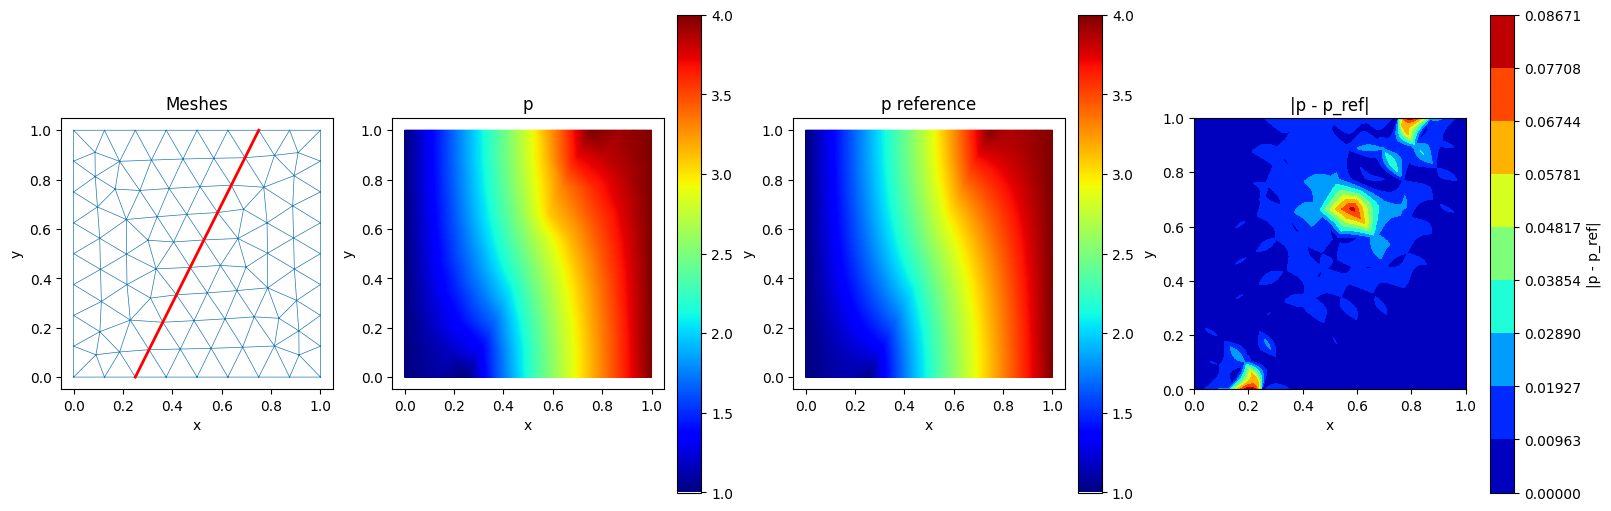

Info    : Reading 'diagonal_fracture_ex1_4.msh'...
Info    : 15 entities
Info    : 349 nodes
Info    : 720 elements
Info    : Done reading 'diagonal_fracture_ex1_4.msh'
DOFs in p_m: 349
DOFs in p_f: 19
DOFs in λ: 19
Total DOFs: 387
  0 SNES Function norm 6.663418245697e+02
  1 SNES Function norm 2.875364865727e-12
Converged in 1 Newton iterations


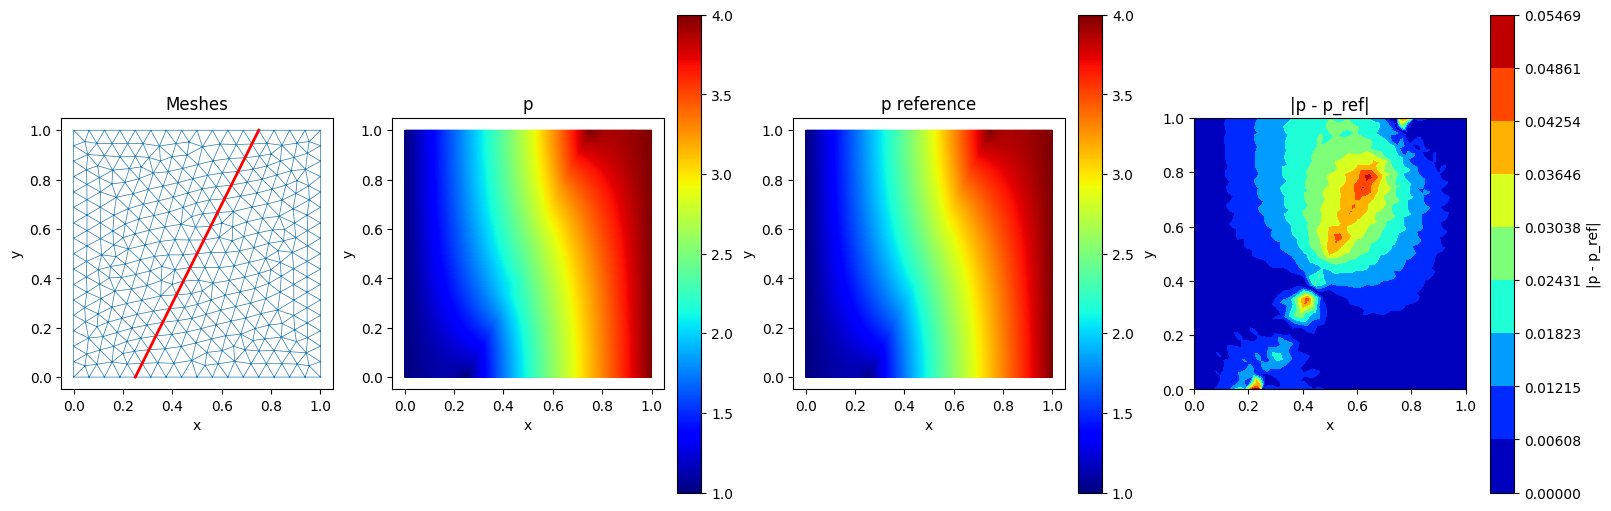

Info    : Reading 'diagonal_fracture_ex1_5.msh'...
Info    : 15 entities
Info    : 1286 nodes
Info    : 2612 elements
Info    : Done reading 'diagonal_fracture_ex1_5.msh'
DOFs in p_m: 1286
DOFs in p_f: 37
DOFs in λ: 37
Total DOFs: 1360
  0 SNES Function norm 1.331995754226e+03
  1 SNES Function norm 2.514707918621e-12
Converged in 1 Newton iterations


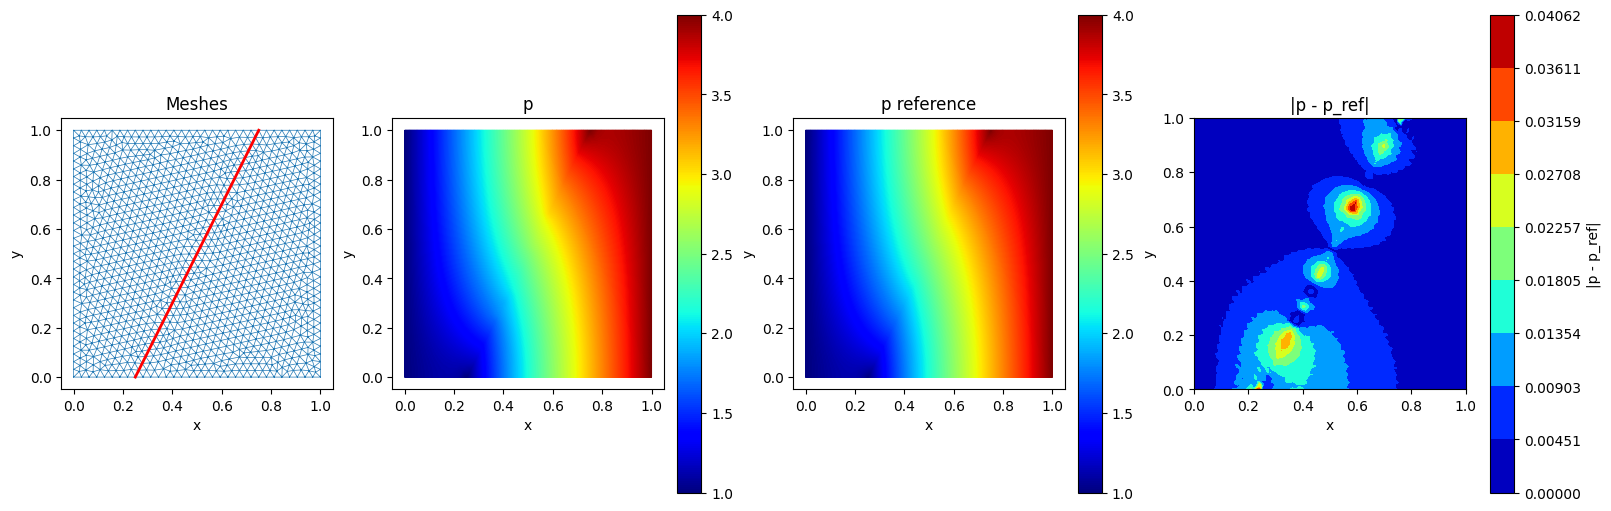

Info    : Reading 'diagonal_fracture_ex1_6.msh'...
Info    : 15 entities
Info    : 4949 nodes
Info    : 9974 elements
Info    : Done reading 'diagonal_fracture_ex1_6.msh'
DOFs in p_m: 4949
DOFs in p_f: 73
DOFs in λ: 73
Total DOFs: 5095
  0 SNES Function norm 2.662938843200e+03
  1 SNES Function norm 7.053000435832e-12
Converged in 1 Newton iterations


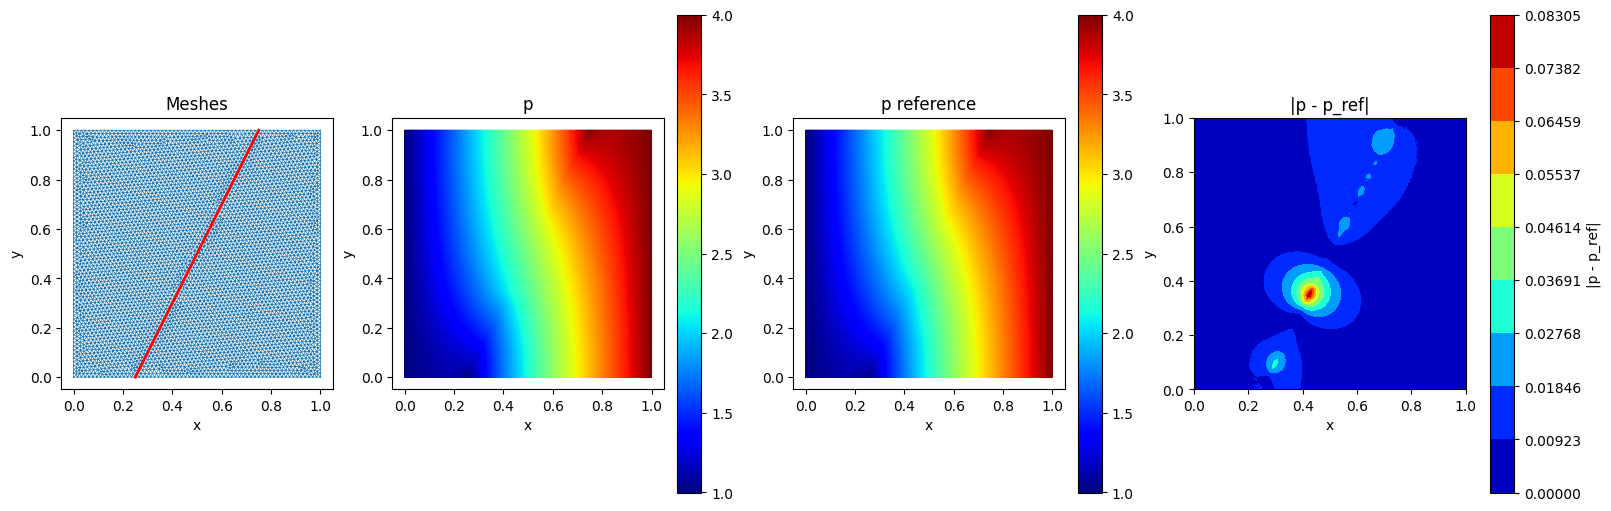

Info    : Reading 'diagonal_fracture_ex1_7.msh'...
Info    : 15 entities
Info    : 19447 nodes
Info    : 39042 elements
Info    : Done reading 'diagonal_fracture_ex1_7.msh'
DOFs in p_m: 19447
DOFs in p_f: 145
DOFs in λ: 145
Total DOFs: 19737
  0 SNES Function norm 5.337560821570e+03
  1 SNES Function norm 2.406288848999e-11
Converged in 1 Newton iterations


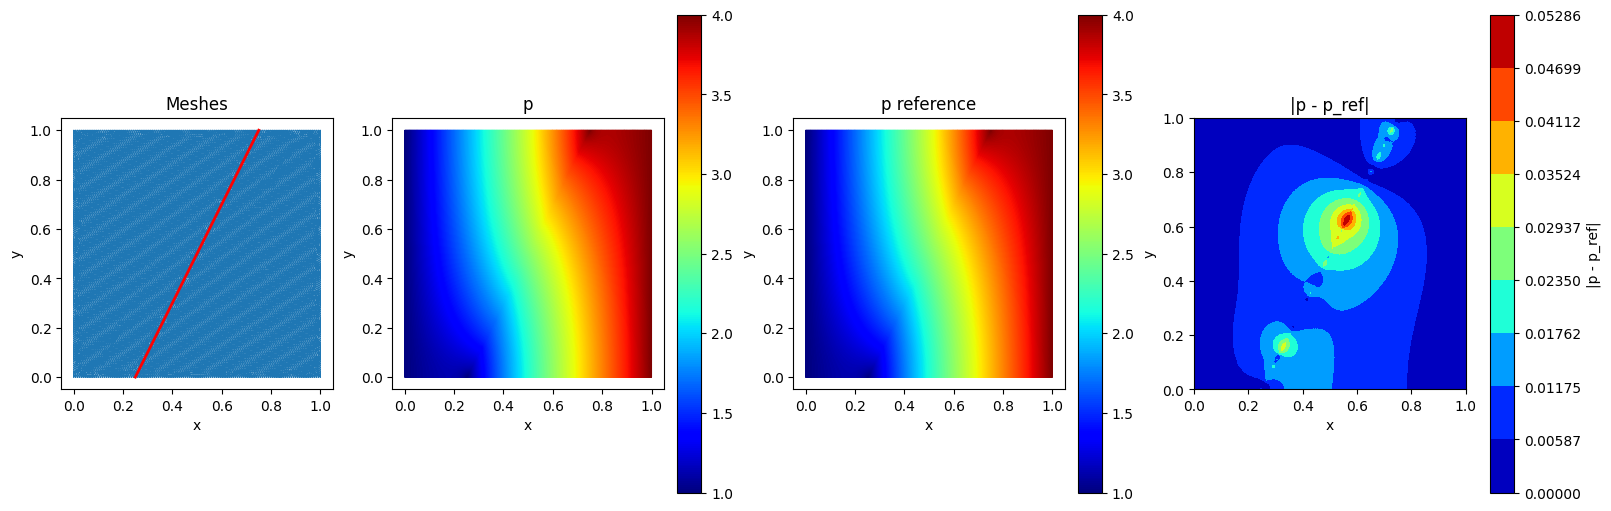

Info    : Reading 'diagonal_fracture_ex1_8.msh'...
Info    : 15 entities
Info    : 76742 nodes
Info    : 153775 elements
Info    : Done reading 'diagonal_fracture_ex1_8.msh'                                                             
DOFs in p_m: 76742
DOFs in p_f: 288
DOFs in λ: 288
Total DOFs: 77318
  0 SNES Function norm 1.116045733372e+04
  1 SNES Function norm 8.084808148928e-11
Converged in 1 Newton iterations


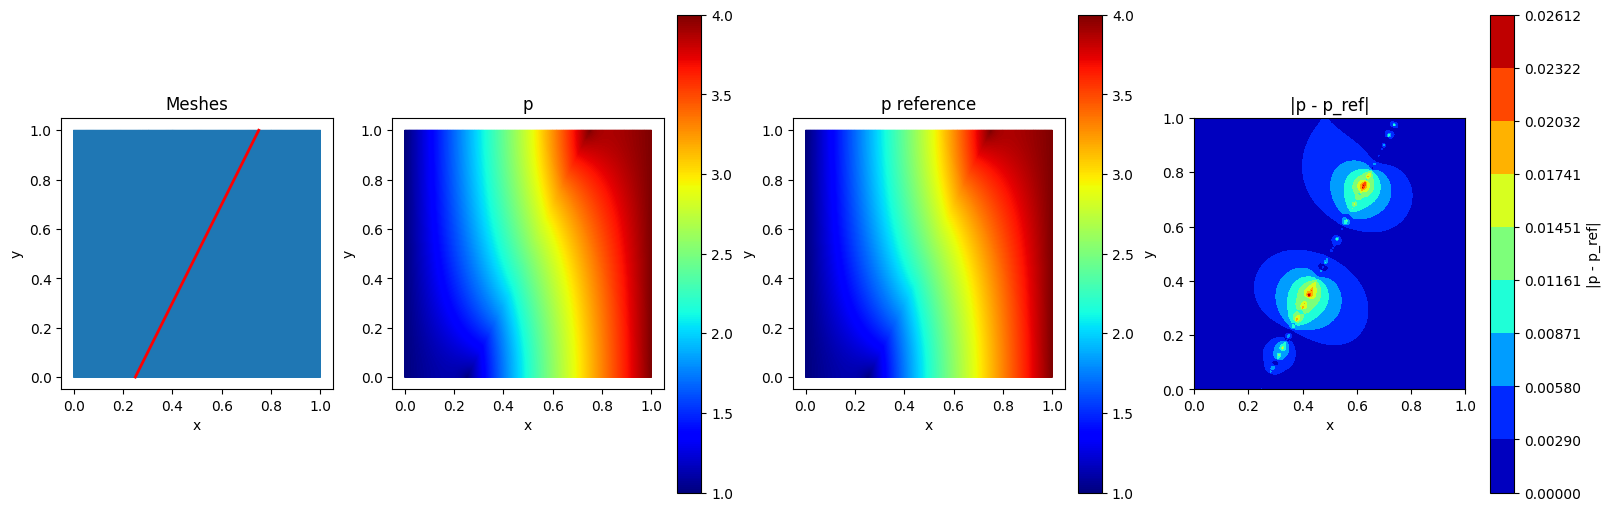

Info    : Reading 'diagonal_fracture_ex1_9.msh'...
Info    : 15 entities
Info    : 304598 nodes
Info    : 609773 elements                                                                                     
Info    : Done reading 'diagonal_fracture_ex1_9.msh'                                                             
DOFs in p_m: 304598
DOFs in p_f: 574
DOFs in λ: 574
Total DOFs: 305746
  0 SNES Function norm 2.214040565180e+04
  1 SNES Function norm 1.629440356384e-10
Converged in 1 Newton iterations


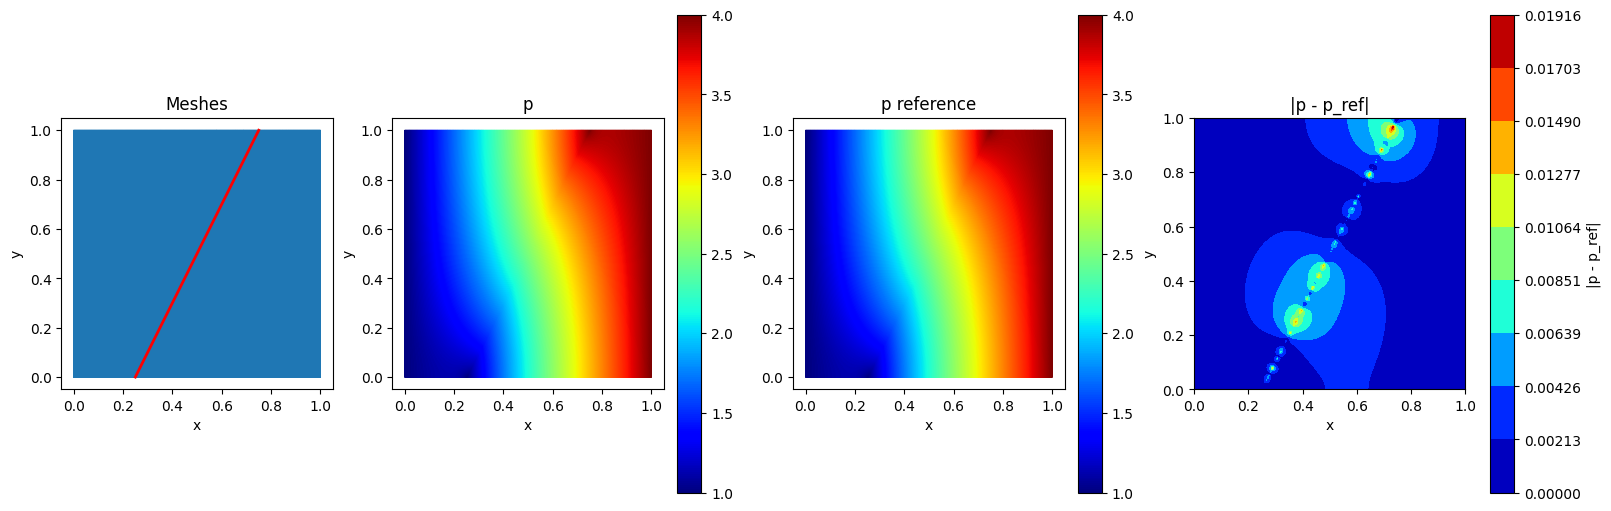

In [5]:
from dolfinx import geometry
def l2_h1_errors(p, p_exact, comm=MPI.COMM_WORLD):
    mesh_fine = p_exact.function_space.mesh
    mesh_coarse = p.function_space.mesh

    tdim = mesh_fine.topology.dim

    # --- Trees on the COARSE mesh (we will evaluate p on the coarse mesh) ---
    bbt_coarse = geometry.bb_tree(mesh_coarse, tdim)
    mid_tree_coarse = geometry.create_midpoint_tree(
        mesh_coarse, tdim,
        np.arange(mesh_coarse.topology.index_map(tdim).size_local, dtype=np.int32)
    )

    # --- Allocate target on the FINE space: p_coarse sampled at fine DoF points ---
    # p_exact is defined on the fine mesh, so reuse its function space
    p_coarse_on_exact = fem.Function(p_exact.function_space)

    def eval_p_coarse_on_points(x: np.ndarray) -> np.ndarray:
        """Return coarse solution p evaluated at points x on the FINE mesh."""
        gdim, N = x.shape
        if gdim == 2:
            X3 = np.column_stack([x.T, np.zeros(N, dtype=np.float64)])  # (N, 3)
        elif gdim == 3:
            X3 = x.T.copy()                                             # (N, 3)
        else:
            raise ValueError(f"Unsupported geometric dimension gdim={gdim}")

        # 1) candidates on COARSE mesh
        cands = geometry.compute_collisions_points(bbt_coarse, X3)
        # 2) filter to true hits
        hits = geometry.compute_colliding_cells(mesh_coarse, cands, X3)

        # 3) pick one owning cell per point
        cells = np.full(N, -1, dtype=np.int32)
        for i in range(N):
            li = hits.links(i)
            if len(li) > 0:
                cells[i] = li[0]

        # Fallback: nearest coarse cell by midpoint
        missing = np.where(cells == -1)[0]
        if missing.size > 0:
            nearest = geometry.compute_closest_entity(
                bbt_coarse, mid_tree_coarse, mesh_coarse, X3[missing]
            )
            cells[missing] = nearest

        # 4) evaluate coarse solution p at those points/cells
        vals_1d = p.eval(X3, cells)  # (N,)
        return np.asarray(vals_1d, dtype=np.float64).reshape(1, N)  # scalar -> (1, N)
        # For vector-valued fields, adapt as in your comment.

    # Interpolate coarse solution into fine space
    p_coarse_on_exact.interpolate(eval_p_coarse_on_points)

    # --- Integrate on the FINE mesh/domain ---
    dx = ufl.dx(domain=mesh_fine)
    err = p_exact - p_coarse_on_exact

    # ||err||_L2^2
    L2_sq_local = fem.assemble_scalar(fem.form(ufl.inner(err, err) * dx))
    L2_sq = comm.allreduce(L2_sq_local, op=MPI.SUM)

    # |err|_H1^2 = ||∇err||_L2^2
    H1_semi_sq_local = fem.assemble_scalar(fem.form(ufl.inner(ufl.grad(err), ufl.grad(err)) * dx))
    H1_semi_sq = comm.allreduce(H1_semi_sq_local, op=MPI.SUM)

    # Norms
    err_L2 = np.sqrt(L2_sq)
    err_H1_semi = np.sqrt(H1_semi_sq)
    err_H1_full = np.sqrt(L2_sq + H1_semi_sq)

    # --- relative errors ---
    # ||p_exact||_L2^2
    L2_exact_sq_local = fem.assemble_scalar(fem.form(ufl.inner(p_coarse_on_exact, p_coarse_on_exact) * dx))
    L2_exact_sq = comm.allreduce(L2_exact_sq_local, op=MPI.SUM)

    # |p_exact|_H1^2
    H1_semi_exact_sq_local = fem.assemble_scalar(
        fem.form(ufl.inner(ufl.grad(p_coarse_on_exact), ufl.grad(p_coarse_on_exact)) * dx)
    )
    H1_semi_exact_sq = comm.allreduce(H1_semi_exact_sq_local, op=MPI.SUM)

    # Norms of exact
    exact_L2 = np.sqrt(L2_exact_sq)
    exact_H1_semi = np.sqrt(H1_semi_exact_sq)
    exact_H1_full = np.sqrt(L2_exact_sq + H1_semi_exact_sq)

    # Relative errors with zero-denominator guard
    rel_L2 = err_L2 / exact_L2 if exact_L2 > 0 else (0.0 if err_L2 == 0 else np.inf)
    rel_H1_semi = err_H1_semi / exact_H1_semi if exact_H1_semi > 0 else (0.0 if err_H1_semi == 0 else np.inf)
    rel_H1_full = err_H1_full / exact_H1_full if exact_H1_full > 0 else (0.0 if err_H1_full == 0 else np.inf)

    return {
        "err_L2": err_L2,
        "err_H1_semi": err_H1_semi,
        "err_H1_full": err_H1_full,
        "rel_L2": rel_L2,
        "rel_H1_semi": rel_H1_semi,   # <-- often what people plot as “H1 error”
        "rel_H1_full": rel_H1_full
    }
    # return err_L2, err_H1_full

for ref in range(N_ref):
    from dolfinx import mesh, fem
    import ufl
    import numpy as np

    # ---------------------------------------------------------------------
    # 1. Mesh and interface tags (similar to Γ tagging in the workshop)
    # ---------------------------------------------------------------------
    # Load Gmsh mesh (2D bulk Ω + 1D interface Γ)
    from dolfinx.io import gmsh as gmshio
    filename = f"diagonal_fracture_ex1_{ref}.msh"
    msh, cell_markers, facet_markers = gmshio.read_from_msh(filename, MPI.COMM_WORLD, 0, gdim=2)[0:3]

    tdim = msh.topology.dim  # 2
    fdim = tdim - 1             # 1

    lc = 1.0/ (2**ref)          # mesh size
    h = lc

    # Find all facets tagged as Gamma (tag=2)
    omega = msh
    gamma_entities = facet_markers.find(2)

    # Create a submesh for Γ (same as gamma in the JSDokken example)
    gamma, gamma_to_omega = mesh.create_submesh(omega, fdim, gamma_entities)[0:2]

    # Define interface tag ID (as defined in Gmsh)
    Gamma_tag = 2  # <-- replace with your actual tag ID for the interface Γ

    # ---------------------------------------------------------------------
    # 2. Function spaces
    # ---------------------------------------------------------------------
    order = 1
    V_m = fem.functionspace(omega, ("Lagrange", order))  # bulk Ω
    V_f = fem.functionspace(gamma, ("Lagrange", order))   # interface Γ
    V_l = fem.functionspace(gamma, ("Lagrange", order))   # multiplier space on Γ
    W = ufl.MixedFunctionSpace(V_m, V_f, V_l)

    # ---------------------------------------------------------------------
    # 3. Trial and Test functions
    # ---------------------------------------------------------------------
    phi, psi, mu = ufl.TestFunctions(W)
    dp_m, dp_f, dl = ufl.TrialFunctions(W)
    p_m = fem.Function(V_m, name="p_m")
    p_f = fem.Function(V_f, name="p_f")
    lmbd = fem.Function(V_f, name="lmbd")

    # ---------------------------------------------------------------------
    # 4. Spatial coordinates and given data
    # ---------------------------------------------------------------------
    x = ufl.SpatialCoordinate(msh)
    f_m = fem.Constant(msh, 0.0)
    f_f = fem.Constant(msh, 0.0)

    k_m = fem.Constant(omega, 1.0)
    k_f = fem.Constant(gamma, 10.0)

    dx = ufl.Measure("dx", domain=omega)
    ds = ufl.Measure("ds", domain=omega, subdomain_data=facet_markers, subdomain_id=Gamma_tag)
    dx_f = ufl.Measure("dx", domain=gamma)

    # ---------------------------------------------------------------------
    # 5. Weak formulations
    # ---------------------------------------------------------------------

    # --- Bulk domain Ω ---------------------------------------------------
    a_m0 = ufl.inner(k_m * ufl.grad(p_m), ufl.grad(phi)) * dx
    a_m1 = -lmbd * phi * ds
    a_m = a_m0 + a_m1
    L_m = f_m * phi * dx

    # --- Interface Γ -----------------------------------------------------
    a_f0 = ufl.inner(k_f * ufl.grad(p_f), ufl.grad(psi)) * ds
    a_f1 = lmbd * psi * ds
    a_f = a_f0 + a_f1
    L_f = f_f * psi * ds

    # --- Lagrange multiplier (constraint tr(p_m) = p_f) ------------------
    a_l0 = p_m * mu * ds
    a_l1 = -p_f * mu * ds
    a_l = a_l0 + a_l1
    L_l = fem.Constant(msh, 0.0) * mu * ds

    # ---------------------------------------------------------------------
    # 6. Combine interface weak form
    # ---------------------------------------------------------------------
    a_gamma = a_f + a_l
    L_gamma = L_f + L_l

    F = a_m - L_m + a_gamma - L_gamma
    residual = ufl.extract_blocks(F)

    jac = ufl.derivative(F, p_m, dp_m) + ufl.derivative(F, p_f, dp_f) + ufl.derivative(F, lmbd, dl)
    J = ufl.extract_blocks(jac)

    # Compute bounding box to locate sides
    coords = omega.geometry.x
    x = coords[:, 0]
    y = coords[:, 1]

    xmin, xmax = x.min(), x.max()
    ymin, ymax = y.min(), y.max()

    # Tolerance for side detection
    tol = 1e-10 * max(xmax - xmin, ymax - ymin)

    # Locate dofs on each side
    left_dofs   = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmin, atol=tol))
    right_dofs  = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[0], xmax, atol=tol))
    bottom_dofs = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymin, atol=tol))
    top_dofs    = fem.locate_dofs_geometrical(V_m, lambda x: np.isclose(x[1], ymax, atol=tol))

    # Union of all boundary dofs for which we enforce a value
    # all_dofs = np.unique(np.concatenate([left_dofs, right_dofs, bottom_dofs, top_dofs]))
    all_dofs = np.unique(np.concatenate([left_dofs, right_dofs]))

    # Build a Function-valued BC so we can assign side-dependent values
    p_m_bc = fem.Function(V_m)
    # p_m_bc.x.array[:] = 1.0  # default 0 (bottom + right)
    p_m_bc.x.array[left_dofs] = 1.0
    p_m_bc.x.array[right_dofs]  = 4.0

    # One BC object over the union of dofs with piecewise values
    bc_pm = fem.dirichletbc(p_m_bc, all_dofs)

    # tolerance scaled to Γ
    tol_g = 1e-10 * np.max(np.ptp(gamma.geometry.x, axis=0))

    # locate dofs at each tip
    tip1_dofs = fem.locate_dofs_geometrical(
        V_f,
        lambda x: np.logical_and(np.isclose(x[0], x_start, atol=tol_g),
                                np.isclose(x[1], y_start, atol=tol_g))
    )
    tip2_dofs = fem.locate_dofs_geometrical(
        V_f,
        lambda x: np.logical_and(np.isclose(x[0], x_end, atol=tol_g),
                                np.isclose(x[1], y_end, atol=tol_g))
    )
    # OR (ii) Different values at the two tips -> two BC objects
    both_tips = np.unique(np.concatenate([tip1_dofs, tip2_dofs]))

    # one Function-valued BC with piecewise values
    pf_fun = fem.Function(V_f)
    # pf_fun.x.array[:] = 0.0
    pf_fun.x.array[tip1_dofs] = 1   # e.g. 1.0
    pf_fun.x.array[tip2_dofs] = 4   # e.g. 3.0

    bc_pf = fem.dirichletbc(pf_fun, both_tips)

    # add it
    bcs = [bc_pm, bc_pf]

    print("DOFs in p_m:", p_m.function_space.dofmap.index_map.size_global)
    print("DOFs in p_f:", p_f.function_space.dofmap.index_map.size_global)
    print("DOFs in λ:", lmbd.function_space.dofmap.index_map.size_global)
    total_dofs = (
        p_m.function_space.dofmap.index_map.size_global
        + p_f.function_space.dofmap.index_map.size_global
        + lmbd.function_space.dofmap.index_map.size_global
    )
    print("Total DOFs:", total_dofs)

    from dolfinx.fem import petsc
    entity_maps = [gamma_to_omega]

    nlp = petsc.NonlinearProblem(
        residual,
        u=[p_m, p_f, lmbd],
        J=J,
        bcs=bcs,
        entity_maps=entity_maps,
        petsc_options={
            "snes_monitor": None,
            "snes_max_it": 200,  # default is 50, set your own limit
            "ksp_type": "preonly",
            "pc_type": "lu",
            "pc_factor_mat_solver_type": "mumps",
            "mat_mumps_icntl_14": 120,
            "ksp_error_if_not_converged": True,
            "snes_error_if_not_converged": True,
        },
        petsc_options_prefix="pmix_",
    )
    max_iterations = 25
    normed_diff = 0
    tol = 1e-5

    nlp.solve()
    iterations = nlp.solver.getIterationNumber()
    print(f"Converged in {iterations} Newton iterations")

    from dolfinx.io import XDMFFile

    # ------------------------------
    # 1) Save bulk field p_m on Ω
    # ------------------------------
    omega_file = outdir / f"omega_ref{ref}.xdmf"
    with XDMFFile(omega.comm, str(omega_file), "w") as xdmf:
        xdmf.write_mesh(omega)
        xdmf.write_function(p_m)

    # ------------------------------
    # 2) Save interface fields p_f, λ on Γ
    # ------------------------------
    gamma_file = outdir / f"gamma_ref{ref}.xdmf"
    with XDMFFile(gamma.comm, str(gamma_file), "w") as xdmf:
        xdmf.write_mesh(gamma)
        xdmf.write_function(p_f)
        xdmf.write_function(lmbd)

    err_dict = l2_h1_errors(p_m, p_m_exact)
    err_dict_pf = l2_h1_errors(p_f, p_f_exact)
    err_dict_lmbd = l2_h1_errors(lmbd, lmbd_exact)
    err_L2_fem, err_H1_fem, rel_L2_fem, rel_H1_full_fem = err_dict["err_L2"], err_dict["err_H1_semi"], err_dict["rel_L2"], err_dict["rel_H1_semi"]
    err_L2_fem_pf, err_H1_fem_pf, rel_L2_fem_pf, rel_H1_full_fem_pf = err_dict_pf["err_L2"], err_dict_pf["err_H1_semi"], err_dict_pf["rel_L2"], err_dict_pf["rel_H1_semi"]
    err_L2_fem_lmbd, err_H1_fem_lmbd, rel_L2_fem_lmbd, rel_H1_full_fem_lmbd = err_dict_lmbd["err_L2"], err_dict_lmbd["err_H1_semi"], err_dict_lmbd["rel_L2"], err_dict_lmbd["rel_H1_semi"]

    import matplotlib.tri as mtri
    import matplotlib.pyplot as plt
    # --- Mesh & spaces ---
    mesh_c = p_m.function_space.mesh           # COARSE mesh
    mesh_f = p_m_exact.function_space.mesh     # FINE mesh
    tdim_c = mesh_c.topology.dim
    tdim_f = mesh_f.topology.dim
    gdim = mesh_f.geometry.dim
    mesh_f.topology.create_connectivity(tdim_f, 0)  # cell -> vertex (you likely already had this)
    mesh_f.topology.create_connectivity(0, tdim_f)  # vertex -> cell (REQUIRED for locate_dofs_topological)

    # Coarse vertex coordinates (in vertex-index order)
    Xv = mesh_f.geometry.x                     # (nverts_local, gdim)
    xv, yv = Xv[:, 0], Xv[:, 1]

    # Cell -> vertex index connectivity (local indices)
    c2v = mesh_f.topology.connectivity(tdim_f, 0).array

    # Build triangle list (works for triangles directly; splits quads if needed)
    ct = mesh_f.topology.cell_type
    if ct in (mesh.CellType.triangle,):
        tris = c2v.reshape(-1, 3)
    elif ct in (mesh.CellType.quadrilateral,):
        # split each quad [a,b,c,d] into triangles [a,b,c] and [a,c,d]
        quads = c2v.reshape(-1, 4)
        tris = np.column_stack([quads[:, [0, 1, 2]], quads[:, [0, 2, 3]]]).reshape(-1, 3)
    else:
        raise NotImplementedError(f"Unsupported 2D cell type: {ct}")

    tri = mtri.Triangulation(xv, yv, tris)

    # --- Build triangulation for the COARSE mesh (for plotting on axes[0]) ---
    mesh_c.topology.create_connectivity(tdim_c, 0)  # cell -> vertex
    mesh_c.topology.create_connectivity(0, tdim_c)  # vertex -> cell

    Xv_c = mesh_c.geometry.x
    xc, yc = Xv_c[:, 0], Xv_c[:, 1]

    c2v_c = mesh_c.topology.connectivity(tdim_c, 0).array
    ct_c = mesh_c.topology.cell_type

    if ct_c == mesh.CellType.triangle:
        tris_c = c2v_c.reshape(-1, 3)
    elif ct_c == mesh.CellType.quadrilateral:
        quads_c = c2v_c.reshape(-1, 4)
        tris_c = np.column_stack(
            [quads_c[:, [0, 1, 2]], quads_c[:, [0, 2, 3]]]
        ).reshape(-1, 3)
    else:
        raise NotImplementedError(f"Unsupported 2D cell type: {ct_c}")

    tri_c = mtri.Triangulation(xc, yc, tris_c)

    # --- 0) get fine dof coordinates as evaluation points ---
    V_f = p_m_exact.function_space
    X_f = V_f.tabulate_dof_coordinates()   # (Nf, gdim)
    Nf = X_f.shape[0]

    # if gdim == 2:
    #     X3_f = np.column_stack([X_f, np.zeros(Nf, dtype=np.float64)])  # (Nf, 3)
    # elif gdim == 3:
    #     X3_f = X_f.copy()                                              # (Nf, 3)
    # else:
    #     raise ValueError(f"Unsupported geometric dimension gdim={gdim}")

    # --- 1) build tree on the COARSE mesh (where p_m lives) ---
    bbt_c = geometry.bb_tree(mesh_c, tdim_c)
    cands = geometry.compute_collisions_points(bbt_c, X_f)
    hits = geometry.compute_colliding_cells(mesh_c, cands, X_f)

    cells = np.full(Nf, -1, dtype=np.int32)
    for i in range(Nf):
        li = hits.links(i)
        if len(li) > 0:
            cells[i] = li[0]

    # robust fallback for any misses (-1), e.g. points on boundaries/tiny roundoff
    missing = np.where(cells == -1)[0]
    if missing.size:
        mid_tree_c = geometry.create_midpoint_tree(
            mesh_c, tdim_c,
            np.arange(mesh_c.topology.index_map(tdim_c).size_local, dtype=np.int32)
        )
        nearest = geometry.compute_closest_entity(bbt_c, mid_tree_c, mesh_c, X_f[missing])
        cells[missing] = nearest

    # --- 2) evaluate p_m (COARSE solution) at those FINE-space coordinates ---
    p_coarse_on_finepts = p_m.eval(X_f, cells).ravel()

    # --- 3) grab the "exact" values at their own fine dofs ---
    # (for standard Lagrange/nodal spaces, coefficient = nodal value)
    p_exact_vals = p_m_exact.x.array.copy().ravel()

    # 4) build plotting arrays (no error norms here)
    x = X_f[:, 0].ravel()
    y = X_f[:, 1].ravel()
    diff_abs = np.abs(p_exact_vals - p_coarse_on_finepts)

    # Common color scale
    vmin = float(min(np.nanmin(p_coarse_on_finepts), np.nanmin(p_exact_vals)))
    vmax = float(max(np.nanmax(p_coarse_on_finepts), np.nanmax(p_exact_vals)))

    # --- Matplotlib plots (nice like VTK, but pure mpl) ---
    fig, axes = plt.subplots(1, 4, figsize=(16, 5), constrained_layout=True)

    # 0) coarse mesh edges only (no fill) to visualize triangulation
    axes[0].triplot(tri_c, linewidth=0.5)
    axes[0].plot([x_start, x_end], [y_start, y_end],
        'r-', linewidth=2, label=r"$\Gamma$")
    axes[0].set_aspect('equal')
    axes[0].set_title("Meshes")

    fig3, ax3 = plt.subplots(figsize=(5, 5))

    mesh_plot = ax3.triplot(tri_c, linewidth=0.5)
    mesh_plot = ax3.plot([x_start, x_end], [y_start, y_end],
        'r-', linewidth=2, label=r"$\Gamma$")
    # ax2.set_title('|p_m - p_m_ref|')
    ax3.set_aspect('equal')

    # fig3.colorbar(cont2, ax=ax2)
    fig3.savefig(f"mesh_{ref}.png", dpi=300, bbox_inches='tight')
    plt.close(fig3)

    # 1) p_m on coarse mesh (vertex coloring with Gouraud shading)
    im1 = axes[1].tripcolor(tri, p_coarse_on_finepts, shading='gouraud', vmin=vmin, vmax=vmax, cmap='jet')
    axes[1].set_aspect('equal')
    axes[1].set_title("p")
    fig.colorbar(im1, ax=axes[1])

    # 2) p_m_exact sampled at coarse vertices
    im2 = axes[2].tripcolor(tri, p_exact_vals, shading='gouraud', vmin=vmin, vmax=vmax, cmap='jet')
    axes[2].set_aspect('equal')
    axes[2].set_title("p reference")
    fig.colorbar(im2, ax=axes[2])

    # Panel 3: absolute difference contours
    levels = np.linspace(diff_abs.min(), np.percentile(diff_abs, 100), 10)
    cont = axes[3].tricontourf(tri, diff_abs, levels=levels, cmap='jet')
    axes[3].set_title('|p - p_ref|')
    axes[3].set_aspect('equal')
    fig.colorbar(cont, ax=axes[3], label='|p - p_ref|')

    fig2, ax2 = plt.subplots(figsize=(5, 5))

    cont2 = ax2.tricontourf(tri, diff_abs, levels=levels, cmap='jet')
    # ax2.set_title('|p_m - p_m_ref|')
    ax2.set_aspect('equal')

    fig2.colorbar(cont2, ax=ax2)
    fig2.savefig(f"error_{ref}.png", dpi=300, bbox_inches='tight')
    plt.close(fig2)

    n = ufl.FacetNormal(omega)
    u = -k_m * ufl.grad(p_m)

    W = fem.functionspace(omega, ("DG", 0))
    w = ufl.TestFunction(W)

    # Measures: bulk facets and fracture cells
    dS_omega = ufl.Measure("dS", domain=omega)   # interior facets of omega
    dS_mm = dS_omega(0)
    ds_omega = ufl.Measure("ds", domain=omega)   # boundary facets of omega
    # dx_gamma = ufl.Measure("dx", domain=gamma)   # cells of fracture mesh
    dx_gamma = ufl.Measure("ds", domain=omega, subdomain_data=facet_markers, subdomain_id=Gamma_tag)

    # Flux residual:
    #   interior faces:     jump(u·n)
    #   boundary faces:     u·n
    #   fracture:           subtract λ where the fracture cuts the bulk
    R_form = (
        ufl.jump(u, n) * ufl.avg(w) * dS_mm
        + ufl.dot(u, n) * w * ds_omega
        - lmbd * w * dx_gamma
    )

    # IMPORTANT: pass entity_maps here as well
    R = fem.form(R_form, entity_maps=entity_maps)
    R_vec = fem.petsc.assemble_vector(R)

    R = fem.Function(W)
    R.x.array[:] = R_vec.array
    R.x.scatter_forward()

    # Compute cell centroids
    mesh = omega
    tdim = mesh.topology.dim
    mesh.topology.create_connectivity(tdim, 0)
    cell_to_vertices = mesh.topology.connectivity(tdim, 0)
    x = mesh.geometry.x

    centroids = np.array([
        x[cell_to_vertices.links(c)].mean(axis=0)
        for c in range(mesh.topology.index_map(tdim).size_local)
    ])

    # Get local residual values (per cell)
    R_local = R.x.array
    fig4, ax4 = plt.subplots(figsize=(5, 5))
    dx_points = ax4.transData.transform((1,0))[0] - ax4.transData.transform((0,0))[0]
    dy_points = ax4.transData.transform((0,1))[1] - ax4.transData.transform((0,0))[1]
    scale = 0.5 * (dx_points + dy_points)

    c = np.sqrt(np.sqrt(3) / (4 * np.pi))  # ≈ 0.37
    r_points = c * h * scale
    s_val = r_points**2
    # cont4 = ax4.scatter(centroids[:, 0], centroids[:, 1], c=R_local, s=s_val, cmap="RdBu_r")
    cont4 = ax4.tripcolor(tri_c, R_local, cmap="RdBu_r")
    ax4.set_aspect('equal')
    ax4.set_xlim(0, 1)
    ax4.set_ylim(0, 1)

    fig4.colorbar(cont4, ax=ax4)
    fig4_name = outdir / f"Flux_imbalance_{ref}.png"
    fig4.savefig(fig4_name, dpi=300, bbox_inches='tight')
    plt.close(fig4)

    for ax in axes:
        ax.set_xlabel('x')
        ax.set_ylabel('y')

    plt.show()
    

    if MPI.COMM_WORLD.rank == 0:
        h_list.append(float(h))
        # L2_list.append(float(L2_err))
        # rL2_list.append(float(rel_L2))
        L2_fem_list.append(float(err_L2_fem))
        rL2s_fem_list.append(float(rel_L2_fem))
        H1s_list.append(float(err_H1_fem))
        rH1s_list.append(float(rel_H1_full_fem))

        L2_fem_list_pf.append(float(err_L2_fem_pf))
        rL2s_fem_list_pf.append(float(rel_L2_fem_pf))
        H1s_list_pf.append(float(err_H1_fem_pf))
        rH1s_list_pf.append(float(rel_H1_full_fem_pf))

        L2_fem_list_lmbd.append(float(err_L2_fem_lmbd))
        rL2s_fem_list_lmbd.append(float(rel_L2_fem_lmbd))
        H1s_list_lmbd.append(float(err_H1_fem_lmbd))
        rH1s_list_lmbd.append(float(rel_H1_full_fem_lmbd))

#     if ref < 8:
#         # Panel 1: MRST (cells)
#         ip = int(ref/4)
#         jp = ref % 4
#         plotter.subplot(ip, jp)
#         plotter.add_mesh(
#             grid_2d, scalars="p_m", cmap="jet", show_edges=True, lighting=True,
#             clim=[1, 4],
#             scalar_bar_args={"title": "FEM p_m", "vertical": True, "width": 0.05, "height": 0.7}
#         )
#         plotter.show_bounds(); plotter.view_xy()
#         plotter.link_views()
# plotter.show()

In [28]:
from math import log
if MPI.COMM_WORLD.rank == 0 and len(h_list) > 0:
    # rates: p_i = log(e_{i-1}/e_i) / log(h_{i-1}/h_i)
    def _roc(errs, hs):
        out = [None]
        for i in range(1, len(errs)):
            e0, e1 = errs[i-1], errs[i]
            h0, h1 = hs[i-1], hs[i]
            if e0 > 0 and e1 > 0 and h0 != h1:
                out.append(log(e0/e1) / log(h0/h1))
            else:
                out.append(None)
        return out

    # roc_L2   = _roc(L2_list,  h_list)
    # roc_rL2  = _roc(rL2_list, h_list)
    roc_L2_fem   = _roc(L2_fem_list,  h_list)
    roc_rL2_fem  = _roc(rL2s_fem_list, h_list)
    roc_H1s  = _roc(H1s_list, h_list)
    roc_rH1s = _roc(rH1s_list, h_list)

    # pretty print
    cols   = ["h", "L2 FEM err", "ROC(L2 FEM)", "H1 FEM err", "ROC(H1 FEM err)"]
    widths = [10, 12, 9, 12, 12]
    header = " ".join(f"{c:>{w}}" for c, w in zip(cols, widths))
    sep = "-" * len(header)
    print(sep)
    print(header)
    print(sep)
    for i in range(len(h_list)):
        row = [
            f"{h_list[i]:.4f}",
            f"{L2_fem_list[i]:.6f}",
            "—" if roc_L2_fem[i]  is None else f"{roc_L2_fem[i]:.3f}",
            f"{H1s_list[i]:.6f}",
            "—" if roc_H1s[i]   is None else f"{roc_H1s[i]:.3f}",
        ]
        print(" ".join(f"{x:>{w}}" for x, w in zip(row, widths)))
    print(sep)

----------------------------------------------------------------
         h   L2 FEM err ROC(L2 FEM)   H1 FEM err ROC(H1 FEM err)
----------------------------------------------------------------
    1.0000     0.091619         —     1.231891            —
    0.5000     0.195328    -1.092     1.032797        0.254
    0.2500     0.042547     2.199     0.492592        1.068
    0.1250     0.013669     1.638     0.312184        0.658
    0.0625     0.015250    -0.158     0.209694        0.574
    0.0312     0.006647     1.198     0.146385        0.519
    0.0156     0.009372    -0.496     0.149729       -0.033
    0.0078     0.010280    -0.133     0.113788        0.396
    0.0039     0.003327     1.628     0.082619        0.462
    0.0020     0.002503     0.411     0.064783        0.351
----------------------------------------------------------------


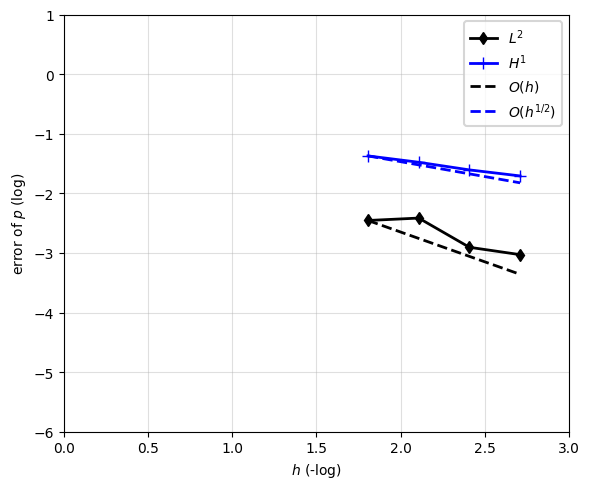

In [5]:
import numpy as np
import matplotlib.pyplot as plt

h = np.array(h_list[-4:], dtype=float)
L2_err = np.array(rL2s_fem_list[-4:], dtype=float)
H1_err = np.array(rH1s_list[-4:], dtype=float)

# Transform axes: x = -log10(h), y = log10(error)
x = -np.log10(h)
y_L2 = np.log10(L2_err)
y_H1 = np.log10(H1_err)

fig, ax = plt.subplots(figsize=(6, 5))

# L2: black line with diamond markers
ax.plot(x, y_L2, '-d', color='black', label=r"$L^2$", lw=2, ms=6)

# H1: blue line with plus markers
ax.plot(x, y_H1, '-+', color='blue', label=r"$H^1$", lw=2, ms=8)

# Reference line O(h): slope = -1 in (x, y) because y = log10(C) - 1*x
# Anchor it at the first L2 point for visibility
k_ref = 1.0
y0 = y_L2[0]
x0 = x[0]
y_ref = y0 - k_ref * (x - x0)
ax.plot(x, y_ref, '--', color='black', lw=2, label=r"$O(h)$")

k_ref = 0.5
y0 = y_H1[0]
x0 = x[0]
y_ref = y0 - k_ref * (x - x0)
ax.plot(x, y_ref, '--', color='blue', lw=2, label=r"$O(h^{1/2})$")

# Labels / ticks / grid
ax.set_xlabel(r"$h$ (-log)")
ax.set_ylabel(r"error of $p$ (log)")
ax.grid(True, which="both", alpha=0.4)

# Optional: match the look in your image
ax.set_xlim(0, 3)
ax.set_ylim(-6,1)

# Legend box
leg = ax.legend(frameon=True)
leg.get_frame().set_linewidth(1.5)

plt.tight_layout()
plt.show()


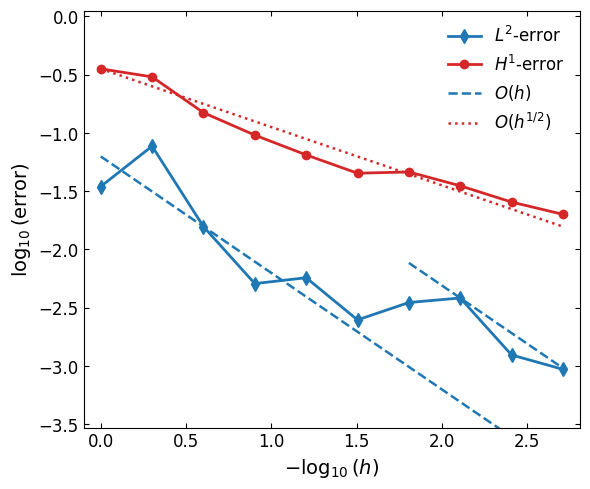

In [44]:
import numpy as np
import matplotlib.pyplot as plt

# Data
h = np.array(h_list[:], dtype=float)
L2_err = np.array(rL2s_fem_list[:], dtype=float)
H1_err = np.array(rH1s_list[:], dtype=float)

# Transform axes
x = -np.log10(h)
y_L2 = np.log10(L2_err)
y_H1 = np.log10(H1_err)

fig, ax = plt.subplots(figsize=(6, 5))

# --- Main curves with color ---
ax.plot(
    x, y_L2, "-d",
    color="tab:blue",
    label=r"$L^2$-error",
    lw=2,
    ms=7,
)

ax.plot(
    x, y_H1, "-o",
    color="tab:red",
    label=r"$H^1$-error",
    lw=2,
    ms=6,
)

# --- Reference lines ---
# O(h): slope = -1
k_ref = 1.0
idx = -3
x0 = x[idx]
y0 = y_L2[idx]
ax.plot(
    x[idx-1:], y0 - k_ref * (x[idx-1:] - x0),
    "--",
    lw=1.8,
    color="tab:blue",
    label=r"$O(h)$"
)

x0 = x[2]
y0 = y_L2[2]
ax.plot(
    x, y0 - k_ref * (x - x0),
    "--",
    lw=1.8,
    color="tab:blue",
    # label=r"$O(h)$"
)

# O(h^{1/2}): slope = -1/2
k_ref = 0.5
x0 = x[0]
y0 = y_H1[0]
ax.plot(
    x, y0 - k_ref * (x - x0),
    ":",
    lw=1.8,
    color="tab:red",
    label=r"$O(h^{1/2})$"
)

# --- Labels & limits ---
ax.set_xlabel(r"$-\log_{10}(h)$", fontsize=14)
ax.set_ylabel(r"$\log_{10}(\text{error})$", fontsize=14)

ax.set_xlim(x.min() - 0.1, x.max() + 0.1)
ax.set_ylim(min(y_L2.min(), y_H1.min()) - 0.5,
            max(y_L2.max(), y_H1.max()) + 0.5)

# No grid
ax.grid(False)

# Ticks
ax.tick_params(direction="in", top=True, right=True, labelsize=12)

# Legend without frame
leg = ax.legend(frameon=False, fontsize=12, loc="best")

plt.tight_layout()
plt.show()


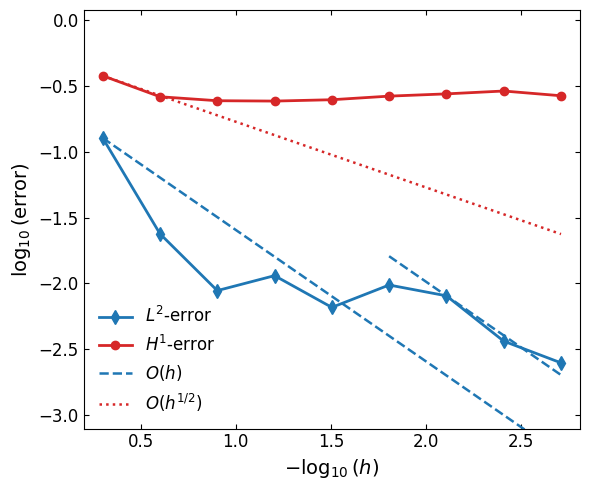

In [46]:
#p_f
import numpy as np
import matplotlib.pyplot as plt

h = np.array(h_list[1:], dtype=float)
L2_err = np.array(rL2s_fem_list_pf[1:], dtype=float)
H1_err = np.array(rH1s_list_pf[1:], dtype=float)

# Transform axes
x = -np.log10(h)
y_L2 = np.log10(L2_err)
y_H1 = np.log10(H1_err)

fig, ax = plt.subplots(figsize=(6, 5))

# --- Main curves with color ---
ax.plot(
    x, y_L2, "-d",
    color="tab:blue",
    label=r"$L^2$-error",
    lw=2,
    ms=7,
)

ax.plot(
    x, y_H1, "-o",
    color="tab:red",
    label=r"$H^1$-error",
    lw=2,
    ms=6,
)

# --- Reference lines ---
# O(h): slope = -1
k_ref = 1.0
idx = -3
x0 = x[idx]
y0 = y_L2[idx]
ax.plot(
    x[idx-1:], y0 - k_ref * (x[idx-1:] - x0),
    "--",
    lw=1.8,
    color="tab:blue",
    label=r"$O(h)$"
)

x0 = x[0]
y0 = y_L2[0]
ax.plot(
    x, y0 - k_ref * (x - x0),
    "--",
    lw=1.8,
    color="tab:blue",
    # label=r"$O(h)$"
)

# O(h^{1/2}): slope = -1/2
k_ref = 0.5
x0 = x[0]
y0 = y_H1[0]
ax.plot(
    x, y0 - k_ref * (x - x0),
    ":",
    lw=1.8,
    color="tab:red",
    label=r"$O(h^{1/2})$"
)

# --- Labels & limits ---
ax.set_xlabel(r"$-\log_{10}(h)$", fontsize=14)
ax.set_ylabel(r"$\log_{10}(\text{error})$", fontsize=14)

ax.set_xlim(x.min() - 0.1, x.max() + 0.1)
ax.set_ylim(min(y_L2.min(), y_H1.min()) - 0.5,
            max(y_L2.max(), y_H1.max()) + 0.5)

# No grid
ax.grid(False)

# Ticks
ax.tick_params(direction="in", top=True, right=True, labelsize=12)

# Legend without frame
leg = ax.legend(frameon=False, fontsize=12, loc="best")

plt.tight_layout()
plt.show()



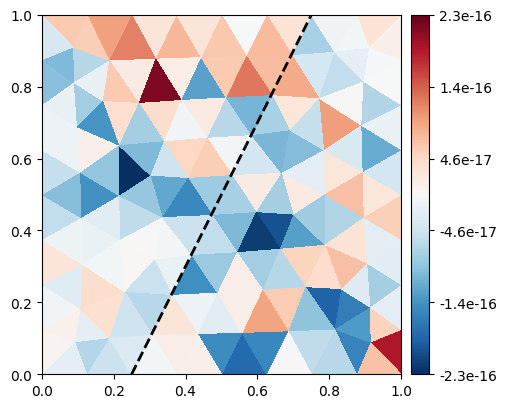

In [26]:
import ufl
n = ufl.FacetNormal(omega)
u = u_m

W = fem.functionspace(omega, ("DG", 0))
w = ufl.TestFunction(W)

# Measures: bulk facets and fracture cells
dS_omega = ufl.Measure("dS", domain=omega)   # interior facets of omega
dS_mm = dS_omega(0)
# dx_gamma = dS_omega(Gamma_tag)
ds_omega = ufl.Measure("ds", domain=omega)   # boundary facets of omega
# dx_gamma = ufl.Measure("dx", domain=gamma)   # cells of fracture mesh
dx_gamma = ufl.Measure("ds", domain=omega, subdomain_data=facet_markers, subdomain_id=Gamma_tag)

# Flux residual:
#   interior faces:     jump(u·n)
#   boundary faces:     u·n
#   fracture:           subtract λ where the fracture cuts the bulk
R_form = (
    # ufl.jump(u, n) * ufl.avg(w) * dS_mm
    ufl.jump(u, n) * ufl.avg(w) * dS_omega
    # + ufl.dot(u, n) * w * ds_omega
    # - lmbd * w * dx_gamma
    # + lmbd * ufl.avg(w) * dx_gamma
)
# R_form = (
#     ufl.dot(u('+'), n('+')) * w('+') * dS_mm
#   + ufl.dot(u('-'), n('-')) * w('-') * dS_mm
#   + ufl.dot(u, n) * w * ds_omega
# #   - lmbd * ufl.avg(w) * dx_gamma
# )


# IMPORTANT: pass entity_maps here as well
R = fem.form(R_form, entity_maps=entity_maps)
R_vec = fem.petsc.assemble_vector(R)

R = fem.Function(W)
R.x.array[:] = R_vec.array
R.x.scatter_forward()

# Compute cell centroids
# mesh = omega
tdim = omega.topology.dim
omega.topology.create_connectivity(tdim, 0)
cell_to_vertices = omega.topology.connectivity(tdim, 0)
x = omega.geometry.x

# Get local residual values (per cell)
R_local = R.x.array
vmin = np.min(R_local)
vmax = np.max(R_local)
vmax_abs = np.max([abs(vmin), abs(vmax)])
# vmax_abs = 0.005
xc, yc = x[:, 0], x[:, 1]

c2v_c = omega.topology.connectivity(tdim, 0).array
ct_c = omega.topology.cell_type

if ct_c == mesh.CellType.triangle:
    tris_c = c2v_c.reshape(-1, 3)
elif ct_c == mesh.CellType.quadrilateral:
    quads_c = c2v_c.reshape(-1, 4)
    tris_c = np.column_stack(
        [quads_c[:, [0, 1, 2]], quads_c[:, [0, 2, 3]]]
    ).reshape(-1, 3)
else:
    raise NotImplementedError(f"Unsupported 2D cell type: {ct_c}")
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
tri_c = mtri.Triangulation(xc, yc, tris_c)

from mpl_toolkits.axes_grid1 import make_axes_locatable

fig4, ax4 = plt.subplots(figsize=(5, 5))

cont4 = ax4.tripcolor(
    tri_c,
    R_local,
    vmin=-vmax_abs,
    vmax=vmax_abs,
    cmap="RdBu_r"
)

ax4.plot(
    [x_start, x_end],
    [y_start, y_end],
    color='black',
    linewidth=2,
    linestyle='--'
)

ax4.set_aspect("equal")
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)

# --- Colorbar with same height as the plot ---
divider = make_axes_locatable(ax4)
cax = divider.append_axes("right", size="5%", pad=0.1)

cbar = fig4.colorbar(cont4, cax=cax)

ticks = np.linspace(-vmax_abs, vmax_abs, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.1e}" for t in ticks])

plt.show()


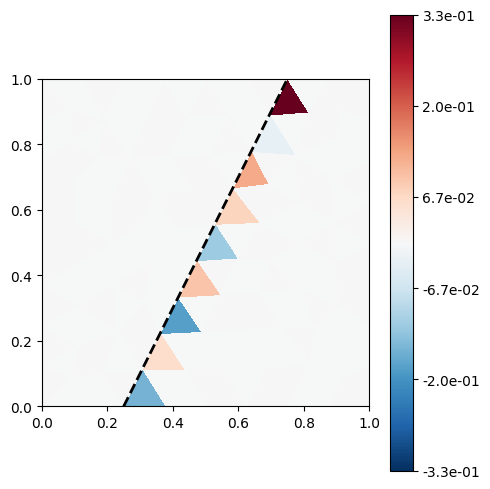

In [30]:
#local conservation using div
import ufl
n = ufl.FacetNormal(omega)
u = u_m

W = fem.functionspace(omega, ("DG", 0))
w = ufl.TestFunction(W)

# Measures: bulk facets and fracture cells
dS_omega = ufl.Measure("dS", domain=omega)   # interior facets of omega
dS_mm = dS_omega(0)
# dx_gamma = dS_omega(Gamma_tag)
ds_omega = ufl.Measure("ds", domain=omega)   # boundary facets of omega
# dx_gamma = ufl.Measure("dx", domain=gamma)   # cells of fracture mesh
dx_gamma = ufl.Measure("ds", domain=omega, subdomain_data=facet_markers, subdomain_id=Gamma_tag)

# Flux residual:
#   interior faces:     jump(u·n)
#   boundary faces:     u·n
#   fracture:           subtract λ where the fracture cuts the bulk
R_form = (
    # ufl.jump(u, n) * ufl.avg(w) * dS_mm
    ufl.div(u) * w * ufl.dx
    # ufl.jump(u, n) * ufl.avg(w) * dS_omega
    # + ufl.dot(u, n) * w * ds_omega
    # - lmbd * w * dx_gamma
    - lmbd * ufl.avg(w) * dx_gamma
)
# R_form = (
#     ufl.dot(u('+'), n('+')) * w('+') * dS_mm
#   + ufl.dot(u('-'), n('-')) * w('-') * dS_mm
#   + ufl.dot(u, n) * w * ds_omega
# #   - lmbd * ufl.avg(w) * dx_gamma
# )


# IMPORTANT: pass entity_maps here as well
R = fem.form(R_form, entity_maps=entity_maps)
R_vec = fem.petsc.assemble_vector(R)

R = fem.Function(W)
R.x.array[:] = R_vec.array
R.x.scatter_forward()

# Compute cell centroids
# mesh = omega
tdim = omega.topology.dim
omega.topology.create_connectivity(tdim, 0)
cell_to_vertices = omega.topology.connectivity(tdim, 0)
x = omega.geometry.x

# Get local residual values (per cell)
R_local = R.x.array
vmin = np.min(R_local)
vmax = np.max(R_local)
vmax_abs = np.max([abs(vmin), abs(vmax)])
# vmax_abs = 0.005
xc, yc = x[:, 0], x[:, 1]

c2v_c = omega.topology.connectivity(tdim, 0).array
ct_c = omega.topology.cell_type

if ct_c == mesh.CellType.triangle:
    tris_c = c2v_c.reshape(-1, 3)
elif ct_c == mesh.CellType.quadrilateral:
    quads_c = c2v_c.reshape(-1, 4)
    tris_c = np.column_stack(
        [quads_c[:, [0, 1, 2]], quads_c[:, [0, 2, 3]]]
    ).reshape(-1, 3)
else:
    raise NotImplementedError(f"Unsupported 2D cell type: {ct_c}")
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
tri_c = mtri.Triangulation(xc, yc, tris_c)

fig4, ax4 = plt.subplots(figsize=(5, 5))

# Tripcolor plot
cont4 = ax4.tripcolor(
    tri_c,
    R_local,
    vmin=-vmax_abs,
    vmax=vmax_abs,
    cmap="RdBu_r"
)

ax4.plot([x_start, x_end], [y_start, y_end], color='black', linewidth=2, linestyle='--')

# Equal aspect and domain limits
ax4.set_aspect("equal")
ax4.set_xlim(0, 1)
ax4.set_ylim(0, 1)

# Correct way to add a colorbar
cbar = fig4.colorbar(cont4, ax=ax4)

# 6 ticks between vmin and vmax (inclusive)
ticks = np.linspace(-vmax_abs, vmax_abs, 6)
cbar.set_ticks(ticks)
cbar.set_ticklabels([f"{t:.1e}" for t in ticks])

plt.tight_layout()
plt.show()


In [28]:
lmbd.x.array

array([ 50.097376  , -55.21213745, -48.10539565,  42.14263579,
       -39.07802822,  35.1252386 , -32.73707002,  36.80227114,
       -37.66193692,  48.44237355])

In [ ]:
from dolfinx.fem.petsc import LinearProblem

# Test and trial on gamma (same space as lambda)
mu = ufl.TestFunction(V_l)
q  = ufl.TrialFunction(V_l)

n = ufl.FacetNormal(omega)
# u = k_m * ufl.grad(p_m)
u = u_m

jump_flux = ufl.jump(u, n)

# Measures
dx_gamma = ufl.Measure("dx", domain=gamma)  # 1D integration on the submesh

# Mass matrix on gamma (no entity_maps needed, everything lives on gamma)
a_proj = ufl.inner(q, mu) * dx_gamma

# RHS: integrate jump_flux (on Omega facets) against mu (on gamma)
#    -> this mixes meshes, so we use entity_maps=[gamma_to_omega]
dS_Gamma = ufl.Measure("dS", domain=omega, subdomain_data=facet_markers, subdomain_id=Gamma_tag)
# dS_Gamma = dS_omega(Gamma_tag)
L_proj = jump_flux * ufl.avg(mu) * dS_Gamma

a_form = fem.form(a_proj)
L_form = fem.form(L_proj, entity_maps=[gamma_to_omega])
# L_form = fem.form(L_proj)

# Solve for q in V_l
q_fun = fem.Function(V_l, name="jump_flux_on_gamma")

proj_problem = LinearProblem(
    a_form,
    L_form,
    u=q_fun,
    bcs=[],
    petsc_options={
        "ksp_type": "preonly",
        "pc_type": "lu",
        "pc_factor_mat_solver_type": "mumps",
    },
    petsc_options_prefix = "jump_u"
)

q_fun = proj_problem.solve()


In [52]:
import numpy as np

diff = q_fun.x.array - lmbd.x.array
print("max |jump_flux - lambda|:", np.max(np.abs(diff)))
print("discrete ||jump_flux - lambda||_2:", np.linalg.norm(diff))


max |jump_flux - lambda|: 3.6633210268757193
discrete ||jump_flux - lambda||_2: 5.922608955083979


In [53]:
q_fun.x.array

array([-1.18390968, -1.5179688 , -0.69233223, -0.29570098, -0.0629308 ,
        0.5095839 ,  1.26076314,  1.38311818,  2.25521069,  3.17726995])

In [15]:
lmbd.x.array

array([ 1.14443303e-15, -3.47424745e-15,  1.06707322e-15, -6.21704260e-16,
        0.00000000e+00,  2.19424803e-16,  3.68898595e-16,  4.45664221e-16,
        0.00000000e+00])